# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [7]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [8]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.349380847965382 -2.602122511534467
actions: 1 0
rewards: 1.0 1.0


In [9]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [10]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [12]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [13]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [120]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [121]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [122]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [123]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [124]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [126]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    #g_loss = -tf.reduce_mean(Qs)
    
    # D
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs)
    return actions_logits, Qs, g_loss, d_loss

In [127]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [128]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [129]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [130]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1000, 4) actions:(1000,)
action size:2


In [131]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
# state_size = 37
# state_size_ = (84, 84, 3)
state_size = 4
action_size = 2
hidden_size = 64             # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
gamma = 0.99                   # future reward discount
memory_size = 1000            # memory capacity
batch_size = 1000             # experience mini-batch size

In [132]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [133]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [137]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 0.1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            #batch = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0 gloss:0.0380 dloss:1.0027 exploreP:0.9998
Episode:1 meanR:15.5000 R:12.0 gloss:0.0780 dloss:1.0038 exploreP:0.9997
Episode:2 meanR:16.6667 R:19.0 gloss:0.1222 dloss:1.0067 exploreP:0.9995
Episode:3 meanR:17.0000 R:18.0 gloss:0.1779 dloss:1.0134 exploreP:0.9993
Episode:4 meanR:17.0000 R:17.0 gloss:0.2295 dloss:1.0194 exploreP:0.9992
Episode:5 meanR:19.0000 R:29.0 gloss:0.3006 dloss:1.0293 exploreP:0.9989
Episode:6 meanR:19.4286 R:22.0 gloss:0.3913 dloss:1.0452 exploreP:0.9987
Episode:7 meanR:18.2500 R:10.0 gloss:0.4587 dloss:1.0611 exploreP:0.9986
Episode:8 meanR:18.6667 R:22.0 gloss:0.5311 dloss:1.0866 exploreP:0.9983
Episode:9 meanR:18.1000 R:13.0 gloss:0.6138 dloss:1.1226 exploreP:0.9982
Episode:10 meanR:21.0909 R:51.0 gloss:0.7894 dloss:1.2088 exploreP:0.9977
Episode:11 meanR:20.9167 R:19.0 gloss:1.0129 dloss:1.3335 exploreP:0.9975
Episode:12 meanR:20.0769 R:10.0 gloss:1.1240 dloss:1.4029 exploreP:0.9974
Episode:13 meanR:20.9286 R:32.0 gloss:1.2993 dlo

Episode:109 meanR:23.1700 R:38.0 gloss:13.5838 dloss:15.3050 exploreP:0.9756
Episode:110 meanR:23.2100 R:55.0 gloss:13.7116 dloss:15.3452 exploreP:0.9750
Episode:111 meanR:23.2800 R:26.0 gloss:13.9481 dloss:15.5381 exploreP:0.9748
Episode:112 meanR:23.2800 R:10.0 gloss:14.0530 dloss:16.0145 exploreP:0.9747
Episode:113 meanR:23.0800 R:12.0 gloss:14.0419 dloss:15.9797 exploreP:0.9746
Episode:114 meanR:23.0100 R:11.0 gloss:13.9613 dloss:16.2234 exploreP:0.9745
Episode:115 meanR:23.0700 R:21.0 gloss:13.7862 dloss:15.7634 exploreP:0.9743
Episode:116 meanR:23.0600 R:12.0 gloss:13.7221 dloss:15.6825 exploreP:0.9742
Episode:117 meanR:23.0300 R:18.0 gloss:13.6899 dloss:15.6265 exploreP:0.9740
Episode:118 meanR:22.7900 R:18.0 gloss:13.6262 dloss:15.7095 exploreP:0.9738
Episode:119 meanR:22.7800 R:16.0 gloss:13.5365 dloss:15.5721 exploreP:0.9737
Episode:120 meanR:22.7800 R:16.0 gloss:13.4079 dloss:15.5286 exploreP:0.9735
Episode:121 meanR:22.9400 R:26.0 gloss:13.2728 dloss:15.0650 exploreP:0.9733

Episode:216 meanR:23.8400 R:46.0 gloss:12.6051 dloss:14.9289 exploreP:0.9514
Episode:217 meanR:23.8200 R:16.0 gloss:12.9524 dloss:15.5895 exploreP:0.9513
Episode:218 meanR:23.7700 R:13.0 gloss:12.6286 dloss:15.2356 exploreP:0.9512
Episode:219 meanR:23.8000 R:19.0 gloss:12.3669 dloss:14.7116 exploreP:0.9510
Episode:220 meanR:23.7400 R:10.0 gloss:12.3583 dloss:14.6954 exploreP:0.9509
Episode:221 meanR:23.7800 R:30.0 gloss:12.2770 dloss:14.6714 exploreP:0.9506
Episode:222 meanR:23.7700 R:13.0 gloss:12.2910 dloss:14.6230 exploreP:0.9505
Episode:223 meanR:24.0100 R:35.0 gloss:12.4535 dloss:14.6796 exploreP:0.9502
Episode:224 meanR:23.8000 R:22.0 gloss:12.8406 dloss:14.9493 exploreP:0.9500
Episode:225 meanR:23.9800 R:33.0 gloss:12.8273 dloss:14.9365 exploreP:0.9496
Episode:226 meanR:24.2400 R:40.0 gloss:12.9712 dloss:15.2376 exploreP:0.9493
Episode:227 meanR:24.5100 R:44.0 gloss:13.0797 dloss:15.2544 exploreP:0.9489
Episode:228 meanR:24.5500 R:23.0 gloss:13.1954 dloss:15.6710 exploreP:0.9486

Episode:323 meanR:22.4900 R:25.0 gloss:12.2565 dloss:14.8173 exploreP:0.9293
Episode:324 meanR:22.3700 R:10.0 gloss:12.1725 dloss:14.4709 exploreP:0.9292
Episode:325 meanR:22.4000 R:36.0 gloss:12.1632 dloss:14.4909 exploreP:0.9288
Episode:326 meanR:22.1900 R:19.0 gloss:12.2989 dloss:14.9322 exploreP:0.9287
Episode:327 meanR:21.9400 R:19.0 gloss:12.0194 dloss:14.4216 exploreP:0.9285
Episode:328 meanR:21.9100 R:20.0 gloss:12.0004 dloss:14.6183 exploreP:0.9283
Episode:329 meanR:21.9200 R:20.0 gloss:11.8272 dloss:14.2437 exploreP:0.9281
Episode:330 meanR:21.9800 R:25.0 gloss:11.9323 dloss:14.3093 exploreP:0.9279
Episode:331 meanR:21.7700 R:16.0 gloss:12.0830 dloss:14.5755 exploreP:0.9277
Episode:332 meanR:21.6400 R:13.0 gloss:12.0923 dloss:14.6286 exploreP:0.9276
Episode:333 meanR:21.6800 R:17.0 gloss:11.9756 dloss:14.6023 exploreP:0.9275
Episode:334 meanR:21.7200 R:14.0 gloss:11.8120 dloss:14.3192 exploreP:0.9273
Episode:335 meanR:21.7500 R:14.0 gloss:11.7161 dloss:14.4286 exploreP:0.9272

Episode:430 meanR:22.3100 R:15.0 gloss:11.4083 dloss:14.1196 exploreP:0.9076
Episode:431 meanR:22.3200 R:17.0 gloss:11.3078 dloss:14.0590 exploreP:0.9075
Episode:432 meanR:22.4300 R:24.0 gloss:11.3558 dloss:14.0651 exploreP:0.9073
Episode:433 meanR:22.3900 R:13.0 gloss:11.3579 dloss:14.2437 exploreP:0.9072
Episode:434 meanR:22.4900 R:24.0 gloss:11.2217 dloss:13.8417 exploreP:0.9069
Episode:435 meanR:22.4700 R:12.0 gloss:11.3313 dloss:14.0788 exploreP:0.9068
Episode:436 meanR:22.0700 R:13.0 gloss:11.2605 dloss:14.1262 exploreP:0.9067
Episode:437 meanR:22.0700 R:14.0 gloss:11.1151 dloss:13.8467 exploreP:0.9066
Episode:438 meanR:22.1800 R:23.0 gloss:11.1010 dloss:13.8455 exploreP:0.9064
Episode:439 meanR:22.2900 R:36.0 gloss:11.0384 dloss:13.8034 exploreP:0.9061
Episode:440 meanR:22.2000 R:22.0 gloss:10.9189 dloss:13.6051 exploreP:0.9059
Episode:441 meanR:22.3400 R:32.0 gloss:10.9752 dloss:13.6240 exploreP:0.9056
Episode:442 meanR:22.3300 R:10.0 gloss:11.1211 dloss:13.9504 exploreP:0.9055

Episode:537 meanR:22.7800 R:21.0 gloss:10.5327 dloss:13.7475 exploreP:0.8864
Episode:538 meanR:22.7800 R:23.0 gloss:10.5695 dloss:13.8192 exploreP:0.8862
Episode:539 meanR:22.7000 R:28.0 gloss:10.6100 dloss:13.7837 exploreP:0.8859
Episode:540 meanR:22.6600 R:18.0 gloss:10.7515 dloss:14.0000 exploreP:0.8858
Episode:541 meanR:22.4400 R:10.0 gloss:10.6881 dloss:13.9567 exploreP:0.8857
Episode:542 meanR:22.4900 R:15.0 gloss:10.5625 dloss:13.9142 exploreP:0.8856
Episode:543 meanR:22.1400 R:12.0 gloss:10.4502 dloss:13.6481 exploreP:0.8855
Episode:544 meanR:22.0900 R:19.0 gloss:10.3912 dloss:13.6402 exploreP:0.8853
Episode:545 meanR:22.1400 R:17.0 gloss:10.4607 dloss:13.7315 exploreP:0.8851
Episode:546 meanR:22.1300 R:12.0 gloss:10.3866 dloss:13.8544 exploreP:0.8850
Episode:547 meanR:21.9700 R:12.0 gloss:10.1865 dloss:13.4469 exploreP:0.8849
Episode:548 meanR:22.1500 R:32.0 gloss:10.1416 dloss:13.3366 exploreP:0.8847
Episode:549 meanR:22.2900 R:41.0 gloss:10.2430 dloss:13.5351 exploreP:0.8843

Episode:644 meanR:20.4400 R:10.0 gloss:10.0479 dloss:12.9958 exploreP:0.8676
Episode:645 meanR:20.3800 R:11.0 gloss:9.9712 dloss:12.9861 exploreP:0.8675
Episode:646 meanR:20.3800 R:12.0 gloss:9.8180 dloss:12.7550 exploreP:0.8674
Episode:647 meanR:20.5700 R:31.0 gloss:9.7386 dloss:12.4961 exploreP:0.8671
Episode:648 meanR:20.7800 R:53.0 gloss:10.0734 dloss:12.9779 exploreP:0.8667
Episode:649 meanR:20.7700 R:40.0 gloss:10.3198 dloss:13.1200 exploreP:0.8663
Episode:650 meanR:20.8300 R:21.0 gloss:10.3364 dloss:12.9940 exploreP:0.8661
Episode:651 meanR:20.8200 R:13.0 gloss:10.3244 dloss:13.1731 exploreP:0.8660
Episode:652 meanR:21.0100 R:63.0 gloss:10.4200 dloss:13.1041 exploreP:0.8655
Episode:653 meanR:21.0800 R:21.0 gloss:10.6506 dloss:13.4619 exploreP:0.8653
Episode:654 meanR:21.1200 R:14.0 gloss:10.6454 dloss:13.5345 exploreP:0.8652
Episode:655 meanR:21.1600 R:25.0 gloss:10.5691 dloss:13.4581 exploreP:0.8650
Episode:656 meanR:21.1300 R:14.0 gloss:10.6433 dloss:13.5592 exploreP:0.8649
Ep

Episode:751 meanR:21.5100 R:10.0 gloss:11.3740 dloss:14.1981 exploreP:0.8478
Episode:752 meanR:21.0300 R:15.0 gloss:11.2299 dloss:14.2159 exploreP:0.8477
Episode:753 meanR:21.2300 R:41.0 gloss:11.1898 dloss:13.9552 exploreP:0.8474
Episode:754 meanR:21.2200 R:13.0 gloss:11.3197 dloss:14.1706 exploreP:0.8472
Episode:755 meanR:21.3700 R:40.0 gloss:11.3302 dloss:14.1194 exploreP:0.8469
Episode:756 meanR:21.4200 R:19.0 gloss:11.4856 dloss:14.3420 exploreP:0.8467
Episode:757 meanR:21.4000 R:12.0 gloss:11.5046 dloss:14.5041 exploreP:0.8466
Episode:758 meanR:21.5100 R:24.0 gloss:11.4270 dloss:14.3167 exploreP:0.8464
Episode:759 meanR:21.4600 R:10.0 gloss:11.5345 dloss:14.8305 exploreP:0.8464
Episode:760 meanR:21.3600 R:16.0 gloss:11.1974 dloss:14.3318 exploreP:0.8462
Episode:761 meanR:21.3600 R:16.0 gloss:10.9888 dloss:13.9327 exploreP:0.8461
Episode:762 meanR:21.4600 R:22.0 gloss:11.0281 dloss:14.0946 exploreP:0.8459
Episode:763 meanR:21.5300 R:17.0 gloss:11.1084 dloss:14.2650 exploreP:0.8458

Episode:858 meanR:22.9800 R:18.0 gloss:10.7757 dloss:13.9693 exploreP:0.8274
Episode:859 meanR:23.0800 R:20.0 gloss:10.7803 dloss:14.0316 exploreP:0.8273
Episode:860 meanR:23.0900 R:17.0 gloss:10.7428 dloss:13.8113 exploreP:0.8271
Episode:861 meanR:23.0800 R:15.0 gloss:10.8346 dloss:14.0471 exploreP:0.8270
Episode:862 meanR:22.9700 R:11.0 gloss:10.8094 dloss:13.9801 exploreP:0.8269
Episode:863 meanR:23.0200 R:22.0 gloss:10.7909 dloss:13.8667 exploreP:0.8268
Episode:864 meanR:22.7800 R:19.0 gloss:10.9672 dloss:14.1287 exploreP:0.8266
Episode:865 meanR:22.7800 R:16.0 gloss:10.8392 dloss:14.0200 exploreP:0.8265
Episode:866 meanR:22.7700 R:10.0 gloss:10.8016 dloss:14.1647 exploreP:0.8264
Episode:867 meanR:22.6900 R:26.0 gloss:10.6399 dloss:13.8024 exploreP:0.8262
Episode:868 meanR:22.4500 R:14.0 gloss:10.7702 dloss:14.1366 exploreP:0.8261
Episode:869 meanR:22.2200 R:14.0 gloss:10.6111 dloss:14.0392 exploreP:0.8259
Episode:870 meanR:21.6500 R:10.0 gloss:10.4669 dloss:13.7317 exploreP:0.8259

Episode:965 meanR:21.2000 R:20.0 gloss:10.1554 dloss:13.3055 exploreP:0.8093
Episode:966 meanR:21.3100 R:21.0 gloss:10.1931 dloss:13.2937 exploreP:0.8092
Episode:967 meanR:21.3600 R:31.0 gloss:10.2386 dloss:13.2699 exploreP:0.8089
Episode:968 meanR:21.4300 R:21.0 gloss:10.3084 dloss:13.4033 exploreP:0.8088
Episode:969 meanR:21.6200 R:33.0 gloss:10.2552 dloss:13.3155 exploreP:0.8085
Episode:970 meanR:21.7400 R:22.0 gloss:10.3482 dloss:13.2873 exploreP:0.8083
Episode:971 meanR:21.5900 R:15.0 gloss:10.3586 dloss:13.3376 exploreP:0.8082
Episode:972 meanR:21.6800 R:24.0 gloss:10.4503 dloss:13.3440 exploreP:0.8080
Episode:973 meanR:21.7000 R:15.0 gloss:10.5685 dloss:13.7166 exploreP:0.8079
Episode:974 meanR:21.8500 R:25.0 gloss:10.4880 dloss:13.5329 exploreP:0.8077
Episode:975 meanR:21.8400 R:21.0 gloss:10.4350 dloss:13.4643 exploreP:0.8075
Episode:976 meanR:22.0800 R:32.0 gloss:10.5463 dloss:13.5564 exploreP:0.8073
Episode:977 meanR:21.9500 R:13.0 gloss:10.6753 dloss:13.9257 exploreP:0.8072

Episode:1071 meanR:25.2500 R:23.0 gloss:11.4188 dloss:16.0234 exploreP:0.7883
Episode:1072 meanR:25.2000 R:19.0 gloss:11.2501 dloss:15.5823 exploreP:0.7881
Episode:1073 meanR:25.2400 R:19.0 gloss:11.3024 dloss:15.8153 exploreP:0.7880
Episode:1074 meanR:25.0900 R:10.0 gloss:11.1276 dloss:15.4936 exploreP:0.7879
Episode:1075 meanR:25.0000 R:12.0 gloss:11.0077 dloss:15.2529 exploreP:0.7878
Episode:1076 meanR:25.1500 R:47.0 gloss:10.9366 dloss:15.3038 exploreP:0.7875
Episode:1077 meanR:25.3900 R:37.0 gloss:11.0124 dloss:15.5079 exploreP:0.7872
Episode:1078 meanR:25.3300 R:27.0 gloss:11.0969 dloss:15.6304 exploreP:0.7870
Episode:1079 meanR:25.2500 R:15.0 gloss:11.2186 dloss:15.8510 exploreP:0.7868
Episode:1080 meanR:25.4000 R:30.0 gloss:11.0583 dloss:15.5471 exploreP:0.7866
Episode:1081 meanR:25.3100 R:16.0 gloss:11.1927 dloss:15.8339 exploreP:0.7865
Episode:1082 meanR:25.2500 R:23.0 gloss:11.1249 dloss:15.4949 exploreP:0.7863
Episode:1083 meanR:25.0600 R:25.0 gloss:11.1619 dloss:15.7269 ex

Episode:1177 meanR:20.5700 R:16.0 gloss:10.2738 dloss:13.8491 exploreP:0.7714
Episode:1178 meanR:20.4400 R:14.0 gloss:10.1980 dloss:13.8202 exploreP:0.7712
Episode:1179 meanR:20.4100 R:12.0 gloss:10.1492 dloss:13.6683 exploreP:0.7712
Episode:1180 meanR:20.3000 R:19.0 gloss:10.1049 dloss:13.5866 exploreP:0.7710
Episode:1181 meanR:20.4200 R:28.0 gloss:10.1993 dloss:13.7798 exploreP:0.7708
Episode:1182 meanR:20.4500 R:26.0 gloss:10.2485 dloss:13.7951 exploreP:0.7706
Episode:1183 meanR:20.3200 R:12.0 gloss:10.2901 dloss:13.9868 exploreP:0.7705
Episode:1184 meanR:20.2800 R:12.0 gloss:10.1671 dloss:13.7902 exploreP:0.7704
Episode:1185 meanR:20.2700 R:16.0 gloss:9.9833 dloss:13.6546 exploreP:0.7703
Episode:1186 meanR:20.1200 R:20.0 gloss:9.7454 dloss:13.3999 exploreP:0.7701
Episode:1187 meanR:20.3400 R:33.0 gloss:9.7542 dloss:13.2883 exploreP:0.7699
Episode:1188 meanR:20.4000 R:18.0 gloss:9.7020 dloss:13.2142 exploreP:0.7698
Episode:1189 meanR:20.5600 R:32.0 gloss:9.7407 dloss:13.3016 explore

Episode:1283 meanR:21.0800 R:12.0 gloss:10.3146 dloss:13.6604 exploreP:0.7546
Episode:1284 meanR:21.1500 R:19.0 gloss:10.1887 dloss:13.3422 exploreP:0.7545
Episode:1285 meanR:21.1700 R:18.0 gloss:10.4180 dloss:13.7050 exploreP:0.7544
Episode:1286 meanR:21.2100 R:24.0 gloss:10.4353 dloss:13.6531 exploreP:0.7542
Episode:1287 meanR:21.1500 R:27.0 gloss:10.5156 dloss:13.8940 exploreP:0.7540
Episode:1288 meanR:21.1800 R:21.0 gloss:10.4342 dloss:13.8395 exploreP:0.7538
Episode:1289 meanR:21.0000 R:14.0 gloss:10.4062 dloss:13.9027 exploreP:0.7537
Episode:1290 meanR:20.9900 R:25.0 gloss:10.3296 dloss:13.7606 exploreP:0.7535
Episode:1291 meanR:20.7600 R:15.0 gloss:10.3059 dloss:13.8450 exploreP:0.7534
Episode:1292 meanR:20.8600 R:23.0 gloss:10.1479 dloss:13.5424 exploreP:0.7533
Episode:1293 meanR:20.8600 R:15.0 gloss:10.2254 dloss:13.6992 exploreP:0.7531
Episode:1294 meanR:20.8600 R:11.0 gloss:10.2119 dloss:13.8113 exploreP:0.7531
Episode:1295 meanR:20.9500 R:29.0 gloss:10.0936 dloss:13.5335 ex

Episode:1389 meanR:19.9100 R:12.0 gloss:9.2631 dloss:13.1053 exploreP:0.7391
Episode:1390 meanR:19.9500 R:29.0 gloss:9.1669 dloss:13.0618 exploreP:0.7389
Episode:1391 meanR:20.0500 R:25.0 gloss:9.2318 dloss:13.1442 exploreP:0.7387
Episode:1392 meanR:19.9900 R:17.0 gloss:9.3959 dloss:13.4393 exploreP:0.7385
Episode:1393 meanR:19.9700 R:13.0 gloss:9.3178 dloss:13.3327 exploreP:0.7385
Episode:1394 meanR:19.9700 R:11.0 gloss:9.3400 dloss:13.3646 exploreP:0.7384
Episode:1395 meanR:19.8700 R:19.0 gloss:9.3329 dloss:13.3317 exploreP:0.7382
Episode:1396 meanR:20.2200 R:55.0 gloss:9.5474 dloss:13.5432 exploreP:0.7378
Episode:1397 meanR:20.1400 R:12.0 gloss:9.8754 dloss:13.9829 exploreP:0.7377
Episode:1398 meanR:20.2500 R:25.0 gloss:9.8031 dloss:13.9481 exploreP:0.7376
Episode:1399 meanR:20.0800 R:12.0 gloss:9.6688 dloss:14.0064 exploreP:0.7375
Episode:1400 meanR:19.9900 R:14.0 gloss:9.4636 dloss:13.6128 exploreP:0.7374
Episode:1401 meanR:20.3400 R:52.0 gloss:9.5622 dloss:13.5978 exploreP:0.7370

Episode:1495 meanR:23.3200 R:16.0 gloss:10.6931 dloss:14.7048 exploreP:0.7214
Episode:1496 meanR:22.9200 R:15.0 gloss:10.6275 dloss:14.7283 exploreP:0.7213
Episode:1497 meanR:23.0800 R:28.0 gloss:10.5678 dloss:14.6634 exploreP:0.7211
Episode:1498 meanR:23.0500 R:22.0 gloss:10.5799 dloss:14.6915 exploreP:0.7210
Episode:1499 meanR:23.1800 R:25.0 gloss:10.4625 dloss:14.4293 exploreP:0.7208
Episode:1500 meanR:23.4200 R:38.0 gloss:10.6368 dloss:14.6255 exploreP:0.7205
Episode:1501 meanR:23.1700 R:27.0 gloss:10.7109 dloss:14.8915 exploreP:0.7203
Episode:1502 meanR:23.4000 R:35.0 gloss:10.7163 dloss:14.8451 exploreP:0.7201
Episode:1503 meanR:23.2800 R:11.0 gloss:10.8663 dloss:14.9618 exploreP:0.7200
Episode:1504 meanR:23.2700 R:25.0 gloss:10.6195 dloss:14.4778 exploreP:0.7198
Episode:1505 meanR:23.3100 R:20.0 gloss:10.5789 dloss:14.5103 exploreP:0.7197
Episode:1506 meanR:23.2100 R:11.0 gloss:10.5697 dloss:14.5582 exploreP:0.7196
Episode:1507 meanR:23.1800 R:22.0 gloss:10.4415 dloss:14.2219 ex

Episode:1601 meanR:22.4600 R:16.0 gloss:10.1608 dloss:14.4635 exploreP:0.7046
Episode:1602 meanR:22.2100 R:10.0 gloss:9.9917 dloss:14.1789 exploreP:0.7045
Episode:1603 meanR:22.2500 R:15.0 gloss:9.8239 dloss:13.7225 exploreP:0.7044
Episode:1604 meanR:22.1000 R:10.0 gloss:9.8480 dloss:13.7848 exploreP:0.7043
Episode:1605 meanR:22.0600 R:16.0 gloss:9.8383 dloss:13.9122 exploreP:0.7042
Episode:1606 meanR:22.2200 R:27.0 gloss:9.7414 dloss:13.7010 exploreP:0.7040
Episode:1607 meanR:22.4700 R:47.0 gloss:9.9561 dloss:13.8431 exploreP:0.7037
Episode:1608 meanR:22.1300 R:19.0 gloss:10.2102 dloss:14.2071 exploreP:0.7036
Episode:1609 meanR:22.6300 R:64.0 gloss:10.2887 dloss:14.3646 exploreP:0.7031
Episode:1610 meanR:22.5700 R:13.0 gloss:10.6265 dloss:15.0678 exploreP:0.7030
Episode:1611 meanR:22.5600 R:22.0 gloss:10.5779 dloss:14.7291 exploreP:0.7029
Episode:1612 meanR:22.6100 R:27.0 gloss:10.7836 dloss:15.0044 exploreP:0.7027
Episode:1613 meanR:22.7600 R:30.0 gloss:10.9210 dloss:15.1266 exploreP

Episode:1707 meanR:25.8000 R:34.0 gloss:12.3965 dloss:16.2068 exploreP:0.6860
Episode:1708 meanR:25.9700 R:36.0 gloss:12.6075 dloss:16.4047 exploreP:0.6858
Episode:1709 meanR:25.4900 R:16.0 gloss:12.6262 dloss:16.8289 exploreP:0.6857
Episode:1710 meanR:25.7700 R:41.0 gloss:12.1364 dloss:16.0656 exploreP:0.6854
Episode:1711 meanR:25.9000 R:35.0 gloss:12.1092 dloss:15.9751 exploreP:0.6852
Episode:1712 meanR:25.9800 R:35.0 gloss:12.1090 dloss:15.9787 exploreP:0.6849
Episode:1713 meanR:25.9200 R:24.0 gloss:12.3329 dloss:16.2455 exploreP:0.6848
Episode:1714 meanR:25.8600 R:20.0 gloss:12.3824 dloss:16.4537 exploreP:0.6846
Episode:1715 meanR:25.8400 R:12.0 gloss:12.3718 dloss:16.6702 exploreP:0.6846
Episode:1716 meanR:25.7400 R:11.0 gloss:12.2765 dloss:16.3407 exploreP:0.6845
Episode:1717 meanR:25.4000 R:26.0 gloss:12.0922 dloss:16.1489 exploreP:0.6843
Episode:1718 meanR:26.1900 R:97.0 gloss:12.2073 dloss:16.3003 exploreP:0.6837
Episode:1719 meanR:26.3200 R:23.0 gloss:12.5493 dloss:16.6199 ex

Episode:1813 meanR:22.8100 R:13.0 gloss:10.3338 dloss:14.0506 exploreP:0.6696
Episode:1814 meanR:22.8700 R:26.0 gloss:10.4318 dloss:14.0950 exploreP:0.6694
Episode:1815 meanR:22.9400 R:19.0 gloss:10.5313 dloss:14.3645 exploreP:0.6693
Episode:1816 meanR:22.9600 R:13.0 gloss:10.4683 dloss:14.3562 exploreP:0.6692
Episode:1817 meanR:22.9000 R:20.0 gloss:10.2649 dloss:14.0789 exploreP:0.6690
Episode:1818 meanR:22.2100 R:28.0 gloss:10.1084 dloss:13.7430 exploreP:0.6689
Episode:1819 meanR:22.4500 R:47.0 gloss:10.4120 dloss:14.1742 exploreP:0.6685
Episode:1820 meanR:22.4700 R:13.0 gloss:10.5345 dloss:14.4373 exploreP:0.6685
Episode:1821 meanR:22.5800 R:24.0 gloss:10.3209 dloss:14.1797 exploreP:0.6683
Episode:1822 meanR:22.8800 R:46.0 gloss:10.4404 dloss:14.3266 exploreP:0.6680
Episode:1823 meanR:23.0700 R:38.0 gloss:10.6811 dloss:14.5564 exploreP:0.6678
Episode:1824 meanR:23.3000 R:36.0 gloss:10.8775 dloss:14.9805 exploreP:0.6675
Episode:1825 meanR:23.0900 R:12.0 gloss:10.8856 dloss:15.2789 ex

Episode:1919 meanR:22.1500 R:32.0 gloss:9.9104 dloss:13.5444 exploreP:0.6541
Episode:1920 meanR:22.1100 R:9.0 gloss:9.8212 dloss:13.5537 exploreP:0.6541
Episode:1921 meanR:22.0300 R:16.0 gloss:9.6909 dloss:13.3620 exploreP:0.6540
Episode:1922 meanR:21.7100 R:14.0 gloss:9.6956 dloss:13.2894 exploreP:0.6539
Episode:1923 meanR:21.7100 R:38.0 gloss:9.7392 dloss:13.4776 exploreP:0.6536
Episode:1924 meanR:21.7800 R:43.0 gloss:9.8498 dloss:13.6837 exploreP:0.6533
Episode:1925 meanR:21.7900 R:13.0 gloss:10.0729 dloss:14.0203 exploreP:0.6533
Episode:1926 meanR:21.9500 R:29.0 gloss:10.0138 dloss:13.7849 exploreP:0.6531
Episode:1927 meanR:21.6400 R:21.0 gloss:10.1020 dloss:13.9477 exploreP:0.6529
Episode:1928 meanR:21.6100 R:15.0 gloss:10.1260 dloss:13.8979 exploreP:0.6528
Episode:1929 meanR:21.5000 R:15.0 gloss:10.0826 dloss:13.9565 exploreP:0.6527
Episode:1930 meanR:21.3400 R:11.0 gloss:9.9287 dloss:13.5804 exploreP:0.6527
Episode:1931 meanR:21.4100 R:21.0 gloss:9.9486 dloss:13.5694 exploreP:0.

Episode:2025 meanR:25.1200 R:42.0 gloss:11.8265 dloss:15.9525 exploreP:0.6373
Episode:2026 meanR:24.9800 R:15.0 gloss:12.3975 dloss:16.6061 exploreP:0.6372
Episode:2027 meanR:25.0400 R:27.0 gloss:12.0038 dloss:15.8252 exploreP:0.6370
Episode:2028 meanR:25.0600 R:17.0 gloss:12.0169 dloss:16.0920 exploreP:0.6369
Episode:2029 meanR:25.0000 R:9.0 gloss:11.9122 dloss:16.2115 exploreP:0.6369
Episode:2030 meanR:25.1100 R:22.0 gloss:11.5940 dloss:15.6600 exploreP:0.6367
Episode:2031 meanR:25.0900 R:19.0 gloss:11.6073 dloss:15.7258 exploreP:0.6366
Episode:2032 meanR:25.1000 R:16.0 gloss:11.6254 dloss:15.7850 exploreP:0.6365
Episode:2033 meanR:25.3500 R:42.0 gloss:11.5731 dloss:15.6585 exploreP:0.6363
Episode:2034 meanR:25.4800 R:27.0 gloss:11.4501 dloss:15.7541 exploreP:0.6361
Episode:2035 meanR:25.3400 R:20.0 gloss:11.1807 dloss:15.4696 exploreP:0.6360
Episode:2036 meanR:25.4500 R:26.0 gloss:11.1386 dloss:15.2151 exploreP:0.6358
Episode:2037 meanR:25.4000 R:15.0 gloss:11.1035 dloss:15.4336 exp

Episode:2132 meanR:19.0300 R:11.0 gloss:7.8979 dloss:11.8378 exploreP:0.6247
Episode:2133 meanR:18.7600 R:15.0 gloss:7.8809 dloss:11.8381 exploreP:0.6246
Episode:2134 meanR:18.6500 R:16.0 gloss:7.7561 dloss:11.7243 exploreP:0.6245
Episode:2135 meanR:18.7200 R:27.0 gloss:7.7916 dloss:11.5688 exploreP:0.6244
Episode:2136 meanR:18.6100 R:15.0 gloss:7.9072 dloss:11.7494 exploreP:0.6243
Episode:2137 meanR:18.6100 R:15.0 gloss:7.8688 dloss:11.7031 exploreP:0.6242
Episode:2138 meanR:18.5600 R:14.0 gloss:7.8250 dloss:11.7560 exploreP:0.6241
Episode:2139 meanR:18.1300 R:12.0 gloss:7.8265 dloss:11.6654 exploreP:0.6240
Episode:2140 meanR:17.9900 R:24.0 gloss:7.8993 dloss:11.6348 exploreP:0.6239
Episode:2141 meanR:17.9400 R:12.0 gloss:7.9436 dloss:11.8687 exploreP:0.6238
Episode:2142 meanR:17.9000 R:10.0 gloss:7.7594 dloss:11.5124 exploreP:0.6237
Episode:2143 meanR:17.7100 R:13.0 gloss:7.7174 dloss:11.5445 exploreP:0.6237
Episode:2144 meanR:17.2500 R:25.0 gloss:7.7361 dloss:11.5190 exploreP:0.6235

Episode:2239 meanR:20.0100 R:42.0 gloss:9.5833 dloss:13.6036 exploreP:0.6118
Episode:2240 meanR:19.9900 R:22.0 gloss:9.5787 dloss:13.6864 exploreP:0.6117
Episode:2241 meanR:20.3900 R:52.0 gloss:9.7792 dloss:13.8310 exploreP:0.6114
Episode:2242 meanR:20.4900 R:20.0 gloss:10.0107 dloss:14.0364 exploreP:0.6113
Episode:2243 meanR:20.6100 R:25.0 gloss:10.0179 dloss:14.1514 exploreP:0.6111
Episode:2244 meanR:20.7000 R:34.0 gloss:10.0326 dloss:14.3634 exploreP:0.6109
Episode:2245 meanR:20.6800 R:25.0 gloss:10.0909 dloss:14.3659 exploreP:0.6108
Episode:2246 meanR:20.6800 R:17.0 gloss:9.9931 dloss:14.3880 exploreP:0.6107
Episode:2247 meanR:20.4600 R:22.0 gloss:9.7947 dloss:14.2468 exploreP:0.6105
Episode:2248 meanR:20.6400 R:36.0 gloss:9.7704 dloss:14.1084 exploreP:0.6103
Episode:2249 meanR:20.6600 R:16.0 gloss:9.7251 dloss:14.0417 exploreP:0.6102
Episode:2250 meanR:20.5600 R:18.0 gloss:9.7255 dloss:14.0621 exploreP:0.6101
Episode:2251 meanR:20.5900 R:18.0 gloss:9.7932 dloss:14.2145 exploreP:0.

Episode:2346 meanR:20.0700 R:11.0 gloss:9.4266 dloss:12.9689 exploreP:0.5987
Episode:2347 meanR:20.0200 R:17.0 gloss:9.3610 dloss:12.9191 exploreP:0.5986
Episode:2348 meanR:19.8600 R:20.0 gloss:9.3820 dloss:12.9633 exploreP:0.5985
Episode:2349 meanR:19.9300 R:23.0 gloss:9.3779 dloss:13.0726 exploreP:0.5984
Episode:2350 meanR:19.9000 R:15.0 gloss:9.4115 dloss:13.3240 exploreP:0.5983
Episode:2351 meanR:19.8800 R:16.0 gloss:9.2188 dloss:13.0312 exploreP:0.5982
Episode:2352 meanR:19.9200 R:21.0 gloss:9.1559 dloss:13.0047 exploreP:0.5981
Episode:2353 meanR:19.8700 R:11.0 gloss:9.1494 dloss:13.2292 exploreP:0.5980
Episode:2354 meanR:19.5600 R:16.0 gloss:8.9716 dloss:12.8891 exploreP:0.5979
Episode:2355 meanR:19.4600 R:15.0 gloss:8.9490 dloss:12.8766 exploreP:0.5978
Episode:2356 meanR:19.3900 R:11.0 gloss:8.9149 dloss:12.9044 exploreP:0.5978
Episode:2357 meanR:19.3000 R:12.0 gloss:8.9176 dloss:12.9904 exploreP:0.5977
Episode:2358 meanR:19.2400 R:13.0 gloss:8.7885 dloss:12.7633 exploreP:0.5976

Episode:2453 meanR:19.1600 R:22.0 gloss:9.2271 dloss:12.8109 exploreP:0.5869
Episode:2454 meanR:19.1400 R:14.0 gloss:9.2672 dloss:13.0253 exploreP:0.5868
Episode:2455 meanR:19.1400 R:15.0 gloss:9.1165 dloss:12.6027 exploreP:0.5867
Episode:2456 meanR:19.1900 R:16.0 gloss:9.2373 dloss:12.8649 exploreP:0.5866
Episode:2457 meanR:19.1800 R:11.0 gloss:9.2913 dloss:12.9498 exploreP:0.5865
Episode:2458 meanR:19.4000 R:35.0 gloss:9.3328 dloss:12.9295 exploreP:0.5863
Episode:2459 meanR:19.2800 R:12.0 gloss:9.4228 dloss:13.2338 exploreP:0.5863
Episode:2460 meanR:19.6400 R:48.0 gloss:9.4643 dloss:13.0029 exploreP:0.5860
Episode:2461 meanR:19.7400 R:38.0 gloss:10.0120 dloss:13.2811 exploreP:0.5858
Episode:2462 meanR:19.7100 R:17.0 gloss:10.0034 dloss:13.2463 exploreP:0.5857
Episode:2463 meanR:19.7100 R:19.0 gloss:9.8543 dloss:13.1368 exploreP:0.5856
Episode:2464 meanR:19.7300 R:13.0 gloss:9.8669 dloss:13.3355 exploreP:0.5855
Episode:2465 meanR:19.7900 R:16.0 gloss:9.7869 dloss:13.3019 exploreP:0.58

Episode:2560 meanR:17.8600 R:14.0 gloss:8.3576 dloss:12.3862 exploreP:0.5758
Episode:2561 meanR:17.6000 R:12.0 gloss:8.1941 dloss:12.2777 exploreP:0.5757
Episode:2562 meanR:17.5900 R:16.0 gloss:8.0861 dloss:11.9343 exploreP:0.5756
Episode:2563 meanR:17.7500 R:35.0 gloss:8.1749 dloss:12.2077 exploreP:0.5754
Episode:2564 meanR:17.7300 R:11.0 gloss:8.2801 dloss:12.5386 exploreP:0.5754
Episode:2565 meanR:17.6900 R:12.0 gloss:8.2061 dloss:12.2549 exploreP:0.5753
Episode:2566 meanR:17.5700 R:9.0 gloss:8.2511 dloss:12.3030 exploreP:0.5753
Episode:2567 meanR:17.6100 R:18.0 gloss:8.1758 dloss:12.2112 exploreP:0.5752
Episode:2568 meanR:17.5800 R:15.0 gloss:8.0416 dloss:11.9731 exploreP:0.5751
Episode:2569 meanR:17.6200 R:18.0 gloss:8.0528 dloss:11.9329 exploreP:0.5750
Episode:2570 meanR:17.8100 R:28.0 gloss:8.1102 dloss:12.0672 exploreP:0.5748
Episode:2571 meanR:17.8300 R:14.0 gloss:8.0754 dloss:12.1329 exploreP:0.5747
Episode:2572 meanR:17.8300 R:14.0 gloss:7.9718 dloss:11.7663 exploreP:0.5746


Episode:2667 meanR:17.0800 R:26.0 gloss:8.2244 dloss:12.2800 exploreP:0.5656
Episode:2668 meanR:17.1600 R:23.0 gloss:8.4716 dloss:12.6477 exploreP:0.5655
Episode:2669 meanR:17.1700 R:19.0 gloss:8.3852 dloss:12.4910 exploreP:0.5653
Episode:2670 meanR:17.1800 R:29.0 gloss:8.3578 dloss:12.4878 exploreP:0.5652
Episode:2671 meanR:17.1300 R:9.0 gloss:8.4785 dloss:13.0312 exploreP:0.5651
Episode:2672 meanR:17.1000 R:11.0 gloss:8.2824 dloss:12.6233 exploreP:0.5651
Episode:2673 meanR:17.7000 R:69.0 gloss:8.4026 dloss:12.5760 exploreP:0.5647
Episode:2674 meanR:17.8800 R:34.0 gloss:8.7018 dloss:13.1600 exploreP:0.5645
Episode:2675 meanR:18.1200 R:33.0 gloss:8.5467 dloss:13.3320 exploreP:0.5643
Episode:2676 meanR:18.0900 R:14.0 gloss:8.5949 dloss:13.6401 exploreP:0.5642
Episode:2677 meanR:18.0000 R:11.0 gloss:8.4588 dloss:13.4476 exploreP:0.5642
Episode:2678 meanR:18.0500 R:16.0 gloss:8.3871 dloss:13.3699 exploreP:0.5641
Episode:2679 meanR:18.1100 R:20.0 gloss:8.3666 dloss:13.4541 exploreP:0.5640


Episode:2774 meanR:17.1000 R:9.0 gloss:7.9370 dloss:11.8132 exploreP:0.5551
Episode:2775 meanR:16.8600 R:9.0 gloss:7.8868 dloss:11.7708 exploreP:0.5551
Episode:2776 meanR:16.8600 R:14.0 gloss:7.8604 dloss:11.6617 exploreP:0.5550
Episode:2777 meanR:16.8800 R:13.0 gloss:7.8113 dloss:11.6130 exploreP:0.5549
Episode:2778 meanR:16.9200 R:20.0 gloss:7.8145 dloss:11.5430 exploreP:0.5548
Episode:2779 meanR:16.9700 R:25.0 gloss:7.8154 dloss:11.7000 exploreP:0.5547
Episode:2780 meanR:17.1000 R:33.0 gloss:7.7408 dloss:11.6642 exploreP:0.5545
Episode:2781 meanR:17.0000 R:23.0 gloss:7.7928 dloss:11.7517 exploreP:0.5544
Episode:2782 meanR:17.0700 R:24.0 gloss:7.7737 dloss:11.7276 exploreP:0.5542
Episode:2783 meanR:16.8200 R:18.0 gloss:7.8222 dloss:11.8626 exploreP:0.5541
Episode:2784 meanR:16.7500 R:18.0 gloss:7.8486 dloss:11.7326 exploreP:0.5540
Episode:2785 meanR:16.7600 R:18.0 gloss:7.9473 dloss:11.8665 exploreP:0.5539
Episode:2786 meanR:16.7700 R:16.0 gloss:7.9798 dloss:11.8696 exploreP:0.5538
E

Episode:2881 meanR:19.8600 R:22.0 gloss:8.0580 dloss:12.4802 exploreP:0.5437
Episode:2882 meanR:19.7200 R:10.0 gloss:7.9864 dloss:12.5019 exploreP:0.5436
Episode:2883 meanR:19.9400 R:40.0 gloss:8.0354 dloss:12.2296 exploreP:0.5434
Episode:2884 meanR:20.2600 R:50.0 gloss:8.3440 dloss:12.4450 exploreP:0.5431
Episode:2885 meanR:20.1800 R:10.0 gloss:8.4330 dloss:13.0111 exploreP:0.5431
Episode:2886 meanR:20.1300 R:11.0 gloss:8.1816 dloss:12.6481 exploreP:0.5430
Episode:2887 meanR:20.1300 R:31.0 gloss:7.9637 dloss:12.2842 exploreP:0.5428
Episode:2888 meanR:20.2500 R:23.0 gloss:8.0353 dloss:12.4487 exploreP:0.5427
Episode:2889 meanR:20.2300 R:12.0 gloss:8.0195 dloss:12.6255 exploreP:0.5427
Episode:2890 meanR:20.2300 R:11.0 gloss:7.9547 dloss:12.4364 exploreP:0.5426
Episode:2891 meanR:20.2400 R:13.0 gloss:7.8899 dloss:12.4091 exploreP:0.5425
Episode:2892 meanR:20.4300 R:33.0 gloss:7.7648 dloss:12.1663 exploreP:0.5424
Episode:2893 meanR:20.2900 R:12.0 gloss:7.8456 dloss:12.5329 exploreP:0.5423

Episode:2988 meanR:21.4400 R:15.0 gloss:8.8811 dloss:13.8652 exploreP:0.5314
Episode:2989 meanR:21.4300 R:11.0 gloss:8.9498 dloss:13.9492 exploreP:0.5314
Episode:2990 meanR:21.5000 R:18.0 gloss:8.9105 dloss:13.9021 exploreP:0.5313
Episode:2991 meanR:21.5700 R:20.0 gloss:8.9002 dloss:13.8709 exploreP:0.5312
Episode:2992 meanR:21.4000 R:16.0 gloss:8.9669 dloss:13.9210 exploreP:0.5311
Episode:2993 meanR:21.4400 R:16.0 gloss:8.9232 dloss:13.8685 exploreP:0.5310
Episode:2994 meanR:21.4900 R:15.0 gloss:8.8907 dloss:13.9523 exploreP:0.5309
Episode:2995 meanR:21.4100 R:16.0 gloss:8.7474 dloss:13.6228 exploreP:0.5308
Episode:2996 meanR:21.3400 R:14.0 gloss:8.6686 dloss:13.6783 exploreP:0.5308
Episode:2997 meanR:21.3100 R:13.0 gloss:8.7147 dloss:13.6361 exploreP:0.5307
Episode:2998 meanR:21.3800 R:17.0 gloss:8.7314 dloss:13.6115 exploreP:0.5306
Episode:2999 meanR:21.3700 R:23.0 gloss:8.7176 dloss:13.6297 exploreP:0.5305
Episode:3000 meanR:21.5900 R:42.0 gloss:8.7453 dloss:13.7623 exploreP:0.5303

Episode:3095 meanR:22.5500 R:17.0 gloss:9.5833 dloss:14.3180 exploreP:0.5192
Episode:3096 meanR:22.5500 R:14.0 gloss:9.5691 dloss:14.3326 exploreP:0.5192
Episode:3097 meanR:22.5800 R:16.0 gloss:9.4646 dloss:14.2982 exploreP:0.5191
Episode:3098 meanR:22.5300 R:12.0 gloss:9.3736 dloss:14.4534 exploreP:0.5190
Episode:3099 meanR:22.5700 R:27.0 gloss:9.1368 dloss:13.8965 exploreP:0.5189
Episode:3100 meanR:22.2600 R:11.0 gloss:9.2925 dloss:14.3195 exploreP:0.5188
Episode:3101 meanR:22.4100 R:26.0 gloss:9.1496 dloss:14.0287 exploreP:0.5187
Episode:3102 meanR:22.5500 R:31.0 gloss:9.3144 dloss:14.0622 exploreP:0.5185
Episode:3103 meanR:22.3600 R:11.0 gloss:9.3244 dloss:14.4103 exploreP:0.5185
Episode:3104 meanR:22.3300 R:17.0 gloss:9.1650 dloss:14.0785 exploreP:0.5184
Episode:3105 meanR:22.3100 R:13.0 gloss:9.1127 dloss:14.0022 exploreP:0.5183
Episode:3106 meanR:22.2600 R:12.0 gloss:9.1759 dloss:14.1621 exploreP:0.5183
Episode:3107 meanR:22.0000 R:9.0 gloss:8.9915 dloss:13.9830 exploreP:0.5182


Episode:3202 meanR:23.0600 R:14.0 gloss:9.1861 dloss:14.4975 exploreP:0.5069
Episode:3203 meanR:23.2000 R:25.0 gloss:9.1719 dloss:14.4387 exploreP:0.5068
Episode:3204 meanR:23.1300 R:10.0 gloss:9.3237 dloss:14.9289 exploreP:0.5068
Episode:3205 meanR:23.1000 R:10.0 gloss:9.2588 dloss:14.8615 exploreP:0.5067
Episode:3206 meanR:23.5800 R:60.0 gloss:9.2242 dloss:14.4300 exploreP:0.5064
Episode:3207 meanR:23.6300 R:14.0 gloss:9.3905 dloss:15.0871 exploreP:0.5063
Episode:3208 meanR:23.7100 R:16.0 gloss:9.3672 dloss:14.8713 exploreP:0.5063
Episode:3209 meanR:23.7500 R:16.0 gloss:9.4010 dloss:15.0084 exploreP:0.5062
Episode:3210 meanR:23.5800 R:15.0 gloss:9.4479 dloss:15.1950 exploreP:0.5061
Episode:3211 meanR:23.2800 R:15.0 gloss:9.3541 dloss:14.9755 exploreP:0.5060
Episode:3212 meanR:23.3000 R:14.0 gloss:9.2730 dloss:15.0539 exploreP:0.5060
Episode:3213 meanR:23.2900 R:14.0 gloss:9.1836 dloss:14.7585 exploreP:0.5059
Episode:3214 meanR:23.0200 R:17.0 gloss:9.0555 dloss:14.8077 exploreP:0.5058

Episode:3309 meanR:20.0600 R:9.0 gloss:8.3146 dloss:12.9713 exploreP:0.4963
Episode:3310 meanR:20.4800 R:57.0 gloss:8.2513 dloss:12.8706 exploreP:0.4961
Episode:3311 meanR:20.4300 R:10.0 gloss:8.2234 dloss:13.0269 exploreP:0.4960
Episode:3312 meanR:20.4000 R:11.0 gloss:8.1679 dloss:12.7374 exploreP:0.4959
Episode:3313 meanR:20.3600 R:10.0 gloss:8.1533 dloss:12.7175 exploreP:0.4959
Episode:3314 meanR:20.4700 R:28.0 gloss:8.0730 dloss:12.6974 exploreP:0.4958
Episode:3315 meanR:20.4600 R:17.0 gloss:8.0879 dloss:12.9457 exploreP:0.4957
Episode:3316 meanR:20.3900 R:12.0 gloss:8.0739 dloss:12.9337 exploreP:0.4956
Episode:3317 meanR:20.4200 R:20.0 gloss:8.0739 dloss:12.8795 exploreP:0.4955
Episode:3318 meanR:20.7700 R:47.0 gloss:8.2289 dloss:12.8386 exploreP:0.4953
Episode:3319 meanR:20.8200 R:16.0 gloss:8.4039 dloss:12.9116 exploreP:0.4952
Episode:3320 meanR:20.9000 R:19.0 gloss:8.4092 dloss:12.9143 exploreP:0.4951
Episode:3321 meanR:20.9100 R:30.0 gloss:8.4976 dloss:13.0363 exploreP:0.4950


Episode:3416 meanR:21.7600 R:19.0 gloss:8.6726 dloss:14.6159 exploreP:0.4852
Episode:3417 meanR:21.7200 R:16.0 gloss:8.6927 dloss:14.6311 exploreP:0.4851
Episode:3418 meanR:21.3600 R:11.0 gloss:8.6617 dloss:14.6410 exploreP:0.4850
Episode:3419 meanR:21.4200 R:22.0 gloss:8.5893 dloss:14.3190 exploreP:0.4849
Episode:3420 meanR:21.4000 R:17.0 gloss:8.7205 dloss:14.4329 exploreP:0.4849
Episode:3421 meanR:21.4300 R:33.0 gloss:8.5485 dloss:14.2056 exploreP:0.4847
Episode:3422 meanR:21.5200 R:21.0 gloss:8.4830 dloss:14.0291 exploreP:0.4846
Episode:3423 meanR:21.4900 R:18.0 gloss:8.5078 dloss:14.1352 exploreP:0.4845
Episode:3424 meanR:21.3300 R:14.0 gloss:8.4774 dloss:13.8471 exploreP:0.4844
Episode:3425 meanR:21.3000 R:20.0 gloss:8.4741 dloss:13.7695 exploreP:0.4844
Episode:3426 meanR:21.4300 R:24.0 gloss:8.6112 dloss:14.0438 exploreP:0.4842
Episode:3427 meanR:21.3000 R:10.0 gloss:8.6662 dloss:14.2328 exploreP:0.4842
Episode:3428 meanR:21.4000 R:21.0 gloss:8.5937 dloss:13.9508 exploreP:0.4841

Episode:3523 meanR:21.0100 R:13.0 gloss:8.9866 dloss:14.5586 exploreP:0.4747
Episode:3524 meanR:20.9900 R:12.0 gloss:8.9529 dloss:14.3875 exploreP:0.4746
Episode:3525 meanR:21.1500 R:36.0 gloss:9.0201 dloss:14.4647 exploreP:0.4744
Episode:3526 meanR:21.1100 R:20.0 gloss:9.1129 dloss:14.7853 exploreP:0.4743
Episode:3527 meanR:21.2100 R:20.0 gloss:8.8698 dloss:14.4764 exploreP:0.4742
Episode:3528 meanR:21.4300 R:43.0 gloss:8.9008 dloss:14.4063 exploreP:0.4740
Episode:3529 meanR:21.4300 R:12.0 gloss:9.0289 dloss:14.7571 exploreP:0.4740
Episode:3530 meanR:21.5000 R:17.0 gloss:9.0080 dloss:14.6922 exploreP:0.4739
Episode:3531 meanR:21.5900 R:21.0 gloss:9.0430 dloss:14.7764 exploreP:0.4738
Episode:3532 meanR:21.7100 R:34.0 gloss:8.9072 dloss:14.8959 exploreP:0.4737
Episode:3533 meanR:21.7200 R:13.0 gloss:8.8026 dloss:14.8411 exploreP:0.4736
Episode:3534 meanR:21.6900 R:16.0 gloss:8.7008 dloss:14.7591 exploreP:0.4735
Episode:3535 meanR:21.6700 R:17.0 gloss:8.6635 dloss:14.5859 exploreP:0.4734

Episode:3630 meanR:23.9100 R:25.0 gloss:9.3799 dloss:15.4053 exploreP:0.4629
Episode:3631 meanR:23.8500 R:15.0 gloss:9.3609 dloss:15.5481 exploreP:0.4629
Episode:3632 meanR:23.7100 R:20.0 gloss:9.1949 dloss:15.4283 exploreP:0.4628
Episode:3633 meanR:23.6700 R:9.0 gloss:9.1098 dloss:15.3190 exploreP:0.4627
Episode:3634 meanR:23.7700 R:26.0 gloss:9.0706 dloss:15.2469 exploreP:0.4626
Episode:3635 meanR:23.8300 R:23.0 gloss:9.1009 dloss:15.5704 exploreP:0.4625
Episode:3636 meanR:23.9200 R:26.0 gloss:8.8276 dloss:15.3407 exploreP:0.4624
Episode:3637 meanR:23.8900 R:12.0 gloss:8.8827 dloss:15.5981 exploreP:0.4624
Episode:3638 meanR:23.9200 R:31.0 gloss:8.7367 dloss:15.1188 exploreP:0.4622
Episode:3639 meanR:23.8300 R:12.0 gloss:8.8840 dloss:15.4273 exploreP:0.4622
Episode:3640 meanR:24.2600 R:61.0 gloss:8.9318 dloss:15.3631 exploreP:0.4619
Episode:3641 meanR:24.2200 R:13.0 gloss:9.1434 dloss:15.5352 exploreP:0.4618
Episode:3642 meanR:24.2200 R:52.0 gloss:9.3248 dloss:15.6339 exploreP:0.4616


Episode:3736 meanR:27.9700 R:27.0 gloss:11.2310 dloss:17.5673 exploreP:0.4499
Episode:3737 meanR:28.0100 R:16.0 gloss:11.0688 dloss:17.3850 exploreP:0.4499
Episode:3738 meanR:27.8900 R:19.0 gloss:10.8671 dloss:17.3137 exploreP:0.4498
Episode:3739 meanR:27.9000 R:13.0 gloss:10.7466 dloss:17.5704 exploreP:0.4497
Episode:3740 meanR:27.6900 R:40.0 gloss:10.4602 dloss:16.8754 exploreP:0.4495
Episode:3741 meanR:27.8400 R:28.0 gloss:10.9004 dloss:17.1607 exploreP:0.4494
Episode:3742 meanR:27.5900 R:27.0 gloss:10.5518 dloss:16.7335 exploreP:0.4493
Episode:3743 meanR:27.4700 R:56.0 gloss:10.5203 dloss:16.5947 exploreP:0.4491
Episode:3744 meanR:27.7000 R:32.0 gloss:10.6095 dloss:16.7990 exploreP:0.4489
Episode:3745 meanR:27.5900 R:11.0 gloss:10.4946 dloss:16.9664 exploreP:0.4489
Episode:3746 meanR:27.3300 R:13.0 gloss:10.3741 dloss:17.0601 exploreP:0.4488
Episode:3747 meanR:27.3800 R:26.0 gloss:10.1554 dloss:16.3301 exploreP:0.4487
Episode:3748 meanR:27.4500 R:34.0 gloss:10.0573 dloss:16.4307 ex

Episode:3843 meanR:24.2800 R:35.0 gloss:8.5241 dloss:14.5687 exploreP:0.4385
Episode:3844 meanR:24.1900 R:23.0 gloss:8.6072 dloss:14.5317 exploreP:0.4384
Episode:3845 meanR:24.3300 R:25.0 gloss:8.6050 dloss:14.1577 exploreP:0.4383
Episode:3846 meanR:24.3300 R:13.0 gloss:8.7849 dloss:14.2944 exploreP:0.4383
Episode:3847 meanR:24.3400 R:27.0 gloss:8.8382 dloss:14.4420 exploreP:0.4381
Episode:3848 meanR:24.2000 R:20.0 gloss:8.7484 dloss:14.5748 exploreP:0.4381
Episode:3849 meanR:24.2000 R:19.0 gloss:8.6766 dloss:14.3968 exploreP:0.4380
Episode:3850 meanR:24.2700 R:27.0 gloss:8.6957 dloss:14.2881 exploreP:0.4379
Episode:3851 meanR:24.2600 R:21.0 gloss:8.8120 dloss:14.5438 exploreP:0.4378
Episode:3852 meanR:24.1900 R:28.0 gloss:8.8320 dloss:14.4696 exploreP:0.4377
Episode:3853 meanR:24.0600 R:12.0 gloss:8.9013 dloss:14.7894 exploreP:0.4376
Episode:3854 meanR:24.0600 R:27.0 gloss:8.6240 dloss:14.2076 exploreP:0.4375
Episode:3855 meanR:24.2200 R:31.0 gloss:8.7076 dloss:14.0880 exploreP:0.4374

Episode:3950 meanR:24.7200 R:20.0 gloss:8.1052 dloss:13.7292 exploreP:0.4274
Episode:3951 meanR:24.6700 R:16.0 gloss:8.1039 dloss:13.9123 exploreP:0.4273
Episode:3952 meanR:24.6000 R:21.0 gloss:8.1017 dloss:13.9277 exploreP:0.4273
Episode:3953 meanR:24.6400 R:16.0 gloss:8.0678 dloss:13.9691 exploreP:0.4272
Episode:3954 meanR:24.5200 R:15.0 gloss:8.0019 dloss:13.6415 exploreP:0.4271
Episode:3955 meanR:24.3300 R:12.0 gloss:8.0232 dloss:13.5099 exploreP:0.4271
Episode:3956 meanR:24.2800 R:17.0 gloss:7.9622 dloss:13.4943 exploreP:0.4270
Episode:3957 meanR:24.3100 R:16.0 gloss:7.9199 dloss:13.5508 exploreP:0.4269
Episode:3958 meanR:24.3200 R:17.0 gloss:7.8803 dloss:13.2797 exploreP:0.4269
Episode:3959 meanR:23.9100 R:17.0 gloss:7.8409 dloss:13.0074 exploreP:0.4268
Episode:3960 meanR:23.6600 R:17.0 gloss:7.8351 dloss:12.9792 exploreP:0.4267
Episode:3961 meanR:23.6900 R:16.0 gloss:7.9151 dloss:13.0558 exploreP:0.4267
Episode:3962 meanR:23.2000 R:12.0 gloss:7.8672 dloss:13.1217 exploreP:0.4266

Episode:4057 meanR:21.6300 R:11.0 gloss:8.5916 dloss:14.3045 exploreP:0.4180
Episode:4058 meanR:21.5900 R:13.0 gloss:8.4444 dloss:14.0452 exploreP:0.4180
Episode:4059 meanR:21.7200 R:30.0 gloss:8.3923 dloss:13.6188 exploreP:0.4178
Episode:4060 meanR:21.7300 R:18.0 gloss:8.4538 dloss:13.7604 exploreP:0.4178
Episode:4061 meanR:21.7800 R:21.0 gloss:8.4325 dloss:13.3780 exploreP:0.4177
Episode:4062 meanR:21.8500 R:19.0 gloss:8.5506 dloss:13.5837 exploreP:0.4176
Episode:4063 meanR:21.3600 R:14.0 gloss:8.5599 dloss:13.6410 exploreP:0.4176
Episode:4064 meanR:21.3200 R:17.0 gloss:8.5651 dloss:13.6122 exploreP:0.4175
Episode:4065 meanR:21.3400 R:25.0 gloss:8.6648 dloss:13.6897 exploreP:0.4174
Episode:4066 meanR:21.8100 R:61.0 gloss:8.7737 dloss:13.7218 exploreP:0.4171
Episode:4067 meanR:21.8100 R:16.0 gloss:8.9084 dloss:14.1708 exploreP:0.4171
Episode:4068 meanR:21.4700 R:13.0 gloss:8.7264 dloss:14.0467 exploreP:0.4170
Episode:4069 meanR:21.4300 R:11.0 gloss:8.5919 dloss:14.0139 exploreP:0.4170

Episode:4164 meanR:23.2700 R:25.0 gloss:8.5735 dloss:13.8904 exploreP:0.4081
Episode:4165 meanR:23.4100 R:39.0 gloss:8.6940 dloss:14.1622 exploreP:0.4080
Episode:4166 meanR:23.0400 R:24.0 gloss:8.8593 dloss:14.4044 exploreP:0.4079
Episode:4167 meanR:23.2200 R:34.0 gloss:8.8659 dloss:14.5643 exploreP:0.4077
Episode:4168 meanR:23.4700 R:38.0 gloss:8.8365 dloss:14.4743 exploreP:0.4076
Episode:4169 meanR:23.5600 R:20.0 gloss:8.9254 dloss:14.8160 exploreP:0.4075
Episode:4170 meanR:23.6500 R:25.0 gloss:9.0875 dloss:14.9829 exploreP:0.4074
Episode:4171 meanR:23.7600 R:34.0 gloss:9.2824 dloss:14.7344 exploreP:0.4073
Episode:4172 meanR:23.6900 R:15.0 gloss:9.3095 dloss:14.9667 exploreP:0.4072
Episode:4173 meanR:23.8000 R:27.0 gloss:9.1930 dloss:14.9406 exploreP:0.4071
Episode:4174 meanR:23.7600 R:16.0 gloss:9.0866 dloss:14.7013 exploreP:0.4070
Episode:4175 meanR:23.8100 R:40.0 gloss:9.0493 dloss:14.6694 exploreP:0.4069
Episode:4176 meanR:23.8100 R:16.0 gloss:9.0644 dloss:14.9968 exploreP:0.4068

Episode:4271 meanR:27.2600 R:70.0 gloss:10.1421 dloss:16.8831 exploreP:0.3966
Episode:4272 meanR:27.4300 R:32.0 gloss:10.4302 dloss:17.3072 exploreP:0.3965
Episode:4273 meanR:27.3100 R:15.0 gloss:10.5846 dloss:17.7459 exploreP:0.3964
Episode:4274 meanR:27.3000 R:15.0 gloss:10.3992 dloss:17.6495 exploreP:0.3963
Episode:4275 meanR:27.0600 R:16.0 gloss:10.0684 dloss:17.0271 exploreP:0.3963
Episode:4276 meanR:27.4500 R:55.0 gloss:10.2621 dloss:16.9942 exploreP:0.3961
Episode:4277 meanR:27.5400 R:28.0 gloss:10.4414 dloss:17.3461 exploreP:0.3960
Episode:4278 meanR:27.7100 R:36.0 gloss:10.5662 dloss:17.1782 exploreP:0.3958
Episode:4279 meanR:27.7100 R:28.0 gloss:10.9375 dloss:17.7842 exploreP:0.3957
Episode:4280 meanR:27.8100 R:42.0 gloss:10.8149 dloss:17.6865 exploreP:0.3955
Episode:4281 meanR:28.1500 R:61.0 gloss:11.0236 dloss:17.7278 exploreP:0.3953
Episode:4282 meanR:28.2900 R:25.0 gloss:11.4104 dloss:17.5490 exploreP:0.3952
Episode:4283 meanR:28.4100 R:27.0 gloss:11.2919 dloss:17.9891 ex

Episode:4377 meanR:30.0300 R:22.0 gloss:9.6153 dloss:17.0585 exploreP:0.3845
Episode:4378 meanR:29.8900 R:22.0 gloss:9.5222 dloss:16.7426 exploreP:0.3845
Episode:4379 meanR:29.7500 R:14.0 gloss:9.4350 dloss:17.0497 exploreP:0.3844
Episode:4380 meanR:29.5200 R:19.0 gloss:9.2093 dloss:16.8827 exploreP:0.3843
Episode:4381 meanR:29.3500 R:44.0 gloss:9.2812 dloss:16.6793 exploreP:0.3842
Episode:4382 meanR:29.3400 R:24.0 gloss:9.4365 dloss:16.7775 exploreP:0.3841
Episode:4383 meanR:29.3600 R:29.0 gloss:9.4988 dloss:16.7139 exploreP:0.3840
Episode:4384 meanR:29.3300 R:19.0 gloss:9.6551 dloss:17.1372 exploreP:0.3839
Episode:4385 meanR:28.9800 R:11.0 gloss:9.5618 dloss:17.0024 exploreP:0.3839
Episode:4386 meanR:28.7900 R:13.0 gloss:9.4784 dloss:17.1040 exploreP:0.3838
Episode:4387 meanR:28.5800 R:10.0 gloss:9.2583 dloss:16.8485 exploreP:0.3838
Episode:4388 meanR:28.5300 R:22.0 gloss:8.9707 dloss:16.1079 exploreP:0.3837
Episode:4389 meanR:28.0700 R:16.0 gloss:8.9713 dloss:16.4397 exploreP:0.3836

Episode:4484 meanR:21.1500 R:18.0 gloss:8.3411 dloss:14.4094 exploreP:0.3761
Episode:4485 meanR:21.1800 R:14.0 gloss:8.2180 dloss:13.9793 exploreP:0.3760
Episode:4486 meanR:21.1700 R:12.0 gloss:8.3042 dloss:14.2856 exploreP:0.3760
Episode:4487 meanR:21.1700 R:10.0 gloss:8.1889 dloss:14.3070 exploreP:0.3759
Episode:4488 meanR:21.1300 R:18.0 gloss:8.0183 dloss:13.8515 exploreP:0.3759
Episode:4489 meanR:21.3000 R:33.0 gloss:8.1339 dloss:14.0660 exploreP:0.3758
Episode:4490 meanR:21.4300 R:26.0 gloss:7.9987 dloss:14.0521 exploreP:0.3757
Episode:4491 meanR:21.3200 R:19.0 gloss:7.9429 dloss:14.0915 exploreP:0.3756
Episode:4492 meanR:21.3400 R:16.0 gloss:7.9487 dloss:14.2945 exploreP:0.3755
Episode:4493 meanR:21.2600 R:11.0 gloss:7.8659 dloss:14.2192 exploreP:0.3755
Episode:4494 meanR:21.4400 R:28.0 gloss:7.7531 dloss:14.0104 exploreP:0.3754
Episode:4495 meanR:21.2800 R:15.0 gloss:7.7955 dloss:14.3361 exploreP:0.3753
Episode:4496 meanR:21.2800 R:22.0 gloss:7.6613 dloss:13.9928 exploreP:0.3753

Episode:4591 meanR:17.8900 R:16.0 gloss:6.6938 dloss:11.9918 exploreP:0.3691
Episode:4592 meanR:17.8300 R:10.0 gloss:6.6865 dloss:12.0974 exploreP:0.3691
Episode:4593 meanR:17.8700 R:15.0 gloss:6.6086 dloss:11.9096 exploreP:0.3690
Episode:4594 meanR:17.7500 R:16.0 gloss:6.6168 dloss:12.0039 exploreP:0.3690
Episode:4595 meanR:17.7900 R:19.0 gloss:6.6662 dloss:12.0347 exploreP:0.3689
Episode:4596 meanR:17.7000 R:13.0 gloss:6.6838 dloss:12.1235 exploreP:0.3688
Episode:4597 meanR:17.6900 R:12.0 gloss:6.6871 dloss:12.1089 exploreP:0.3688
Episode:4598 meanR:17.6000 R:19.0 gloss:6.5914 dloss:12.0162 exploreP:0.3687
Episode:4599 meanR:17.3500 R:21.0 gloss:6.5451 dloss:12.0102 exploreP:0.3687
Episode:4600 meanR:17.3300 R:15.0 gloss:6.5359 dloss:12.0353 exploreP:0.3686
Episode:4601 meanR:17.2700 R:19.0 gloss:6.5960 dloss:11.9880 exploreP:0.3685
Episode:4602 meanR:17.3200 R:20.0 gloss:6.7483 dloss:12.1119 exploreP:0.3685
Episode:4603 meanR:17.4300 R:27.0 gloss:6.7430 dloss:12.0657 exploreP:0.3684

Episode:4698 meanR:17.0300 R:13.0 gloss:6.4622 dloss:12.0586 exploreP:0.3627
Episode:4699 meanR:16.9500 R:13.0 gloss:6.4074 dloss:11.8792 exploreP:0.3626
Episode:4700 meanR:16.9200 R:12.0 gloss:6.4145 dloss:11.8781 exploreP:0.3626
Episode:4701 meanR:17.0400 R:31.0 gloss:6.4720 dloss:11.8894 exploreP:0.3625
Episode:4702 meanR:16.9700 R:13.0 gloss:6.7195 dloss:12.1933 exploreP:0.3624
Episode:4703 meanR:16.9500 R:25.0 gloss:6.6910 dloss:11.8394 exploreP:0.3623
Episode:4704 meanR:17.0600 R:25.0 gloss:6.7286 dloss:12.0413 exploreP:0.3623
Episode:4705 meanR:17.0600 R:12.0 gloss:6.7279 dloss:12.2603 exploreP:0.3622
Episode:4706 meanR:17.0900 R:18.0 gloss:6.5955 dloss:11.9606 exploreP:0.3622
Episode:4707 meanR:17.1600 R:20.0 gloss:6.5728 dloss:12.0621 exploreP:0.3621
Episode:4708 meanR:17.2700 R:20.0 gloss:6.5460 dloss:11.8377 exploreP:0.3620
Episode:4709 meanR:17.2200 R:11.0 gloss:6.6283 dloss:12.0449 exploreP:0.3620
Episode:4710 meanR:17.2400 R:17.0 gloss:6.5567 dloss:11.9885 exploreP:0.3619

Episode:4805 meanR:17.8700 R:12.0 gloss:6.4556 dloss:12.1650 exploreP:0.3560
Episode:4806 meanR:17.9300 R:24.0 gloss:6.4902 dloss:12.3222 exploreP:0.3559
Episode:4807 meanR:17.8900 R:16.0 gloss:6.5467 dloss:12.3901 exploreP:0.3558
Episode:4808 meanR:17.8700 R:18.0 gloss:6.4686 dloss:12.3495 exploreP:0.3558
Episode:4809 meanR:17.9500 R:19.0 gloss:6.4819 dloss:12.2157 exploreP:0.3557
Episode:4810 meanR:18.0100 R:23.0 gloss:6.5482 dloss:12.3725 exploreP:0.3556
Episode:4811 meanR:18.0400 R:21.0 gloss:6.6321 dloss:12.5507 exploreP:0.3556
Episode:4812 meanR:17.9700 R:9.0 gloss:6.5317 dloss:12.3690 exploreP:0.3555
Episode:4813 meanR:18.0000 R:16.0 gloss:6.5582 dloss:12.2880 exploreP:0.3555
Episode:4814 meanR:18.2300 R:37.0 gloss:6.5459 dloss:12.2151 exploreP:0.3553
Episode:4815 meanR:18.2000 R:11.0 gloss:6.6578 dloss:12.5122 exploreP:0.3553
Episode:4816 meanR:18.1300 R:9.0 gloss:6.5231 dloss:12.2890 exploreP:0.3553
Episode:4817 meanR:18.1200 R:11.0 gloss:6.3396 dloss:11.8972 exploreP:0.3552
E

Episode:4912 meanR:17.4000 R:14.0 gloss:6.6747 dloss:11.7508 exploreP:0.3496
Episode:4913 meanR:17.3400 R:10.0 gloss:6.6551 dloss:11.5896 exploreP:0.3495
Episode:4914 meanR:17.2200 R:25.0 gloss:6.6158 dloss:11.4536 exploreP:0.3494
Episode:4915 meanR:17.3100 R:20.0 gloss:6.5618 dloss:11.5678 exploreP:0.3494
Episode:4916 meanR:17.4000 R:18.0 gloss:6.6058 dloss:11.6620 exploreP:0.3493
Episode:4917 meanR:17.3800 R:9.0 gloss:6.6243 dloss:11.8993 exploreP:0.3493
Episode:4918 meanR:17.4000 R:14.0 gloss:6.5066 dloss:11.5492 exploreP:0.3492
Episode:4919 meanR:17.3500 R:13.0 gloss:6.5830 dloss:11.5772 exploreP:0.3492
Episode:4920 meanR:17.3100 R:9.0 gloss:6.6217 dloss:11.6536 exploreP:0.3492
Episode:4921 meanR:17.2500 R:8.0 gloss:6.6122 dloss:11.6668 exploreP:0.3491
Episode:4922 meanR:17.3000 R:20.0 gloss:6.5159 dloss:11.3554 exploreP:0.3491
Episode:4923 meanR:17.2500 R:19.0 gloss:6.6005 dloss:11.4752 exploreP:0.3490
Episode:4924 meanR:17.1400 R:16.0 gloss:6.6808 dloss:11.5864 exploreP:0.3490
Ep

Episode:5019 meanR:15.1600 R:16.0 gloss:5.6757 dloss:10.5160 exploreP:0.3441
Episode:5020 meanR:15.1700 R:10.0 gloss:5.6278 dloss:10.5090 exploreP:0.3441
Episode:5021 meanR:15.2700 R:18.0 gloss:5.5623 dloss:10.3942 exploreP:0.3440
Episode:5022 meanR:15.1700 R:10.0 gloss:5.5824 dloss:10.4991 exploreP:0.3440
Episode:5023 meanR:15.1300 R:15.0 gloss:5.5722 dloss:10.4761 exploreP:0.3439
Episode:5024 meanR:15.1500 R:18.0 gloss:5.5691 dloss:10.4845 exploreP:0.3439
Episode:5025 meanR:15.1100 R:16.0 gloss:5.5762 dloss:10.5432 exploreP:0.3438
Episode:5026 meanR:15.1600 R:14.0 gloss:5.5926 dloss:10.6142 exploreP:0.3438
Episode:5027 meanR:15.2000 R:14.0 gloss:5.6391 dloss:10.6333 exploreP:0.3437
Episode:5028 meanR:15.1400 R:12.0 gloss:5.6764 dloss:10.6423 exploreP:0.3437
Episode:5029 meanR:15.1700 R:11.0 gloss:5.5247 dloss:10.4207 exploreP:0.3436
Episode:5030 meanR:15.0900 R:10.0 gloss:5.4462 dloss:10.3183 exploreP:0.3436
Episode:5031 meanR:15.0700 R:9.0 gloss:5.3880 dloss:10.2265 exploreP:0.3436


Episode:5127 meanR:14.4600 R:13.0 gloss:5.2584 dloss:10.6581 exploreP:0.3389
Episode:5128 meanR:14.4500 R:11.0 gloss:5.2902 dloss:10.5514 exploreP:0.3389
Episode:5129 meanR:14.4800 R:14.0 gloss:5.3192 dloss:10.5841 exploreP:0.3388
Episode:5130 meanR:14.4900 R:11.0 gloss:5.2917 dloss:10.5875 exploreP:0.3388
Episode:5131 meanR:14.4900 R:9.0 gloss:5.2612 dloss:10.5797 exploreP:0.3388
Episode:5132 meanR:14.4700 R:11.0 gloss:5.2299 dloss:10.6046 exploreP:0.3387
Episode:5133 meanR:14.4300 R:15.0 gloss:5.2020 dloss:10.4094 exploreP:0.3387
Episode:5134 meanR:14.4700 R:17.0 gloss:5.2208 dloss:10.3320 exploreP:0.3386
Episode:5135 meanR:14.5800 R:23.0 gloss:5.3034 dloss:10.4474 exploreP:0.3386
Episode:5136 meanR:14.6200 R:14.0 gloss:5.3902 dloss:10.5831 exploreP:0.3385
Episode:5137 meanR:14.6100 R:8.0 gloss:5.3576 dloss:10.4711 exploreP:0.3385
Episode:5138 meanR:14.8300 R:32.0 gloss:5.3119 dloss:10.4822 exploreP:0.3384
Episode:5139 meanR:14.7900 R:13.0 gloss:5.3896 dloss:10.6628 exploreP:0.3383
E

Episode:5234 meanR:15.8400 R:12.0 gloss:5.1854 dloss:10.5322 exploreP:0.3335
Episode:5235 meanR:15.7100 R:10.0 gloss:5.1906 dloss:10.4944 exploreP:0.3334
Episode:5236 meanR:15.7300 R:16.0 gloss:5.2010 dloss:10.4683 exploreP:0.3334
Episode:5237 meanR:15.7600 R:11.0 gloss:5.1879 dloss:10.3223 exploreP:0.3333
Episode:5238 meanR:15.5400 R:10.0 gloss:5.1538 dloss:10.2112 exploreP:0.3333
Episode:5239 meanR:15.5400 R:13.0 gloss:5.1247 dloss:10.0507 exploreP:0.3333
Episode:5240 meanR:15.4200 R:13.0 gloss:5.1766 dloss:10.2232 exploreP:0.3332
Episode:5241 meanR:15.5500 R:26.0 gloss:5.1989 dloss:10.1828 exploreP:0.3331
Episode:5242 meanR:15.6500 R:20.0 gloss:5.3731 dloss:10.4044 exploreP:0.3331
Episode:5243 meanR:15.7000 R:13.0 gloss:5.4799 dloss:10.4467 exploreP:0.3330
Episode:5244 meanR:15.7200 R:13.0 gloss:5.4682 dloss:10.4995 exploreP:0.3330
Episode:5245 meanR:15.7300 R:12.0 gloss:5.4439 dloss:10.4585 exploreP:0.3330
Episode:5246 meanR:15.5800 R:17.0 gloss:5.4326 dloss:10.5587 exploreP:0.3329

Episode:5341 meanR:14.1800 R:9.0 gloss:5.1895 dloss:10.2182 exploreP:0.3286
Episode:5342 meanR:14.1300 R:15.0 gloss:5.1476 dloss:10.1571 exploreP:0.3285
Episode:5343 meanR:14.0800 R:8.0 gloss:5.1544 dloss:10.2497 exploreP:0.3285
Episode:5344 meanR:14.1000 R:15.0 gloss:5.1765 dloss:10.1668 exploreP:0.3285
Episode:5345 meanR:14.1400 R:16.0 gloss:5.2029 dloss:10.2070 exploreP:0.3284
Episode:5346 meanR:14.1200 R:15.0 gloss:5.2071 dloss:10.0504 exploreP:0.3284
Episode:5347 meanR:14.1500 R:13.0 gloss:5.2150 dloss:10.1663 exploreP:0.3283
Episode:5348 meanR:14.0000 R:10.0 gloss:5.1817 dloss:10.1399 exploreP:0.3283
Episode:5349 meanR:13.9800 R:28.0 gloss:5.3074 dloss:10.1001 exploreP:0.3282
Episode:5350 meanR:13.9500 R:14.0 gloss:5.4037 dloss:10.2856 exploreP:0.3282
Episode:5351 meanR:13.9600 R:11.0 gloss:5.3949 dloss:10.2866 exploreP:0.3281
Episode:5352 meanR:14.0000 R:14.0 gloss:5.3145 dloss:10.3036 exploreP:0.3281
Episode:5353 meanR:13.9700 R:10.0 gloss:5.2736 dloss:10.2535 exploreP:0.3281
E

Episode:5449 meanR:13.1600 R:11.0 gloss:4.8267 dloss:9.5138 exploreP:0.3241
Episode:5450 meanR:13.1200 R:10.0 gloss:4.8390 dloss:9.5823 exploreP:0.3240
Episode:5451 meanR:13.1100 R:10.0 gloss:4.7689 dloss:9.4056 exploreP:0.3240
Episode:5452 meanR:13.1200 R:15.0 gloss:4.7513 dloss:9.4425 exploreP:0.3239
Episode:5453 meanR:13.1500 R:13.0 gloss:4.7362 dloss:9.4531 exploreP:0.3239
Episode:5454 meanR:13.1200 R:11.0 gloss:4.7013 dloss:9.5032 exploreP:0.3239
Episode:5455 meanR:13.1300 R:15.0 gloss:4.7529 dloss:9.4352 exploreP:0.3238
Episode:5456 meanR:13.1100 R:13.0 gloss:4.7891 dloss:9.5090 exploreP:0.3238
Episode:5457 meanR:13.1200 R:12.0 gloss:4.7481 dloss:9.5066 exploreP:0.3237
Episode:5458 meanR:13.1400 R:12.0 gloss:4.6791 dloss:9.4078 exploreP:0.3237
Episode:5459 meanR:13.1500 R:13.0 gloss:4.6659 dloss:9.4578 exploreP:0.3237
Episode:5460 meanR:13.1700 R:12.0 gloss:4.6334 dloss:9.4662 exploreP:0.3236
Episode:5461 meanR:13.1600 R:12.0 gloss:4.5726 dloss:9.4505 exploreP:0.3236
Episode:5462

Episode:5557 meanR:13.6200 R:10.0 gloss:4.8635 dloss:9.7286 exploreP:0.3195
Episode:5558 meanR:13.8200 R:32.0 gloss:4.9050 dloss:9.9069 exploreP:0.3194
Episode:5559 meanR:13.7900 R:10.0 gloss:4.8905 dloss:10.0973 exploreP:0.3194
Episode:5560 meanR:13.7700 R:10.0 gloss:4.8085 dloss:9.7680 exploreP:0.3193
Episode:5561 meanR:13.8200 R:17.0 gloss:4.7876 dloss:9.7508 exploreP:0.3193
Episode:5562 meanR:13.7600 R:8.0 gloss:4.8256 dloss:10.0030 exploreP:0.3193
Episode:5563 meanR:13.7700 R:10.0 gloss:4.7579 dloss:9.7803 exploreP:0.3192
Episode:5564 meanR:13.7900 R:15.0 gloss:4.7483 dloss:9.7413 exploreP:0.3192
Episode:5565 meanR:13.7600 R:11.0 gloss:4.7601 dloss:9.8222 exploreP:0.3191
Episode:5566 meanR:13.7900 R:14.0 gloss:4.7707 dloss:9.7401 exploreP:0.3191
Episode:5567 meanR:13.8400 R:18.0 gloss:4.8589 dloss:9.7524 exploreP:0.3191
Episode:5568 meanR:13.7900 R:11.0 gloss:4.9171 dloss:9.8854 exploreP:0.3190
Episode:5569 meanR:13.8000 R:11.0 gloss:4.9262 dloss:9.8597 exploreP:0.3190
Episode:557

Episode:5665 meanR:13.3000 R:12.0 gloss:4.6412 dloss:9.5092 exploreP:0.3151
Episode:5666 meanR:13.2900 R:13.0 gloss:4.6462 dloss:9.4971 exploreP:0.3150
Episode:5667 meanR:13.2900 R:18.0 gloss:4.6890 dloss:9.5363 exploreP:0.3150
Episode:5668 meanR:13.3300 R:15.0 gloss:4.6499 dloss:9.5911 exploreP:0.3149
Episode:5669 meanR:13.3500 R:13.0 gloss:4.6941 dloss:9.6144 exploreP:0.3149
Episode:5670 meanR:13.3700 R:13.0 gloss:4.6636 dloss:9.6446 exploreP:0.3148
Episode:5671 meanR:13.3600 R:10.0 gloss:4.6403 dloss:9.5216 exploreP:0.3148
Episode:5672 meanR:13.3500 R:15.0 gloss:4.6694 dloss:9.5420 exploreP:0.3148
Episode:5673 meanR:13.3000 R:10.0 gloss:4.6479 dloss:9.5763 exploreP:0.3147
Episode:5674 meanR:13.3000 R:13.0 gloss:4.6471 dloss:9.5027 exploreP:0.3147
Episode:5675 meanR:13.2400 R:11.0 gloss:4.6415 dloss:9.4978 exploreP:0.3147
Episode:5676 meanR:13.2400 R:15.0 gloss:4.6566 dloss:9.5351 exploreP:0.3146
Episode:5677 meanR:13.2400 R:13.0 gloss:4.6421 dloss:9.4866 exploreP:0.3146
Episode:5678

Episode:5773 meanR:13.9600 R:18.0 gloss:5.7251 dloss:10.1046 exploreP:0.3105
Episode:5774 meanR:13.9800 R:15.0 gloss:5.8172 dloss:10.1715 exploreP:0.3105
Episode:5775 meanR:14.0100 R:14.0 gloss:5.8132 dloss:10.1538 exploreP:0.3104
Episode:5776 meanR:13.9900 R:13.0 gloss:5.7897 dloss:10.1867 exploreP:0.3104
Episode:5777 meanR:13.9600 R:10.0 gloss:5.7012 dloss:10.0967 exploreP:0.3104
Episode:5778 meanR:13.9700 R:10.0 gloss:5.6495 dloss:10.0080 exploreP:0.3103
Episode:5779 meanR:13.9300 R:12.0 gloss:5.6104 dloss:10.0217 exploreP:0.3103
Episode:5780 meanR:13.9700 R:14.0 gloss:5.5647 dloss:9.9496 exploreP:0.3102
Episode:5781 meanR:14.1100 R:25.0 gloss:5.6913 dloss:10.0338 exploreP:0.3102
Episode:5782 meanR:14.0900 R:12.0 gloss:5.7106 dloss:10.1500 exploreP:0.3101
Episode:5783 meanR:14.1500 R:16.0 gloss:5.6578 dloss:10.0678 exploreP:0.3101
Episode:5784 meanR:14.0900 R:12.0 gloss:5.6989 dloss:10.1513 exploreP:0.3101
Episode:5785 meanR:14.0400 R:10.0 gloss:5.6943 dloss:10.1539 exploreP:0.3100


Episode:5880 meanR:14.2700 R:18.0 gloss:5.2179 dloss:10.1060 exploreP:0.3060
Episode:5881 meanR:14.1300 R:11.0 gloss:5.2422 dloss:10.2280 exploreP:0.3060
Episode:5882 meanR:14.2000 R:19.0 gloss:5.3008 dloss:10.1809 exploreP:0.3059
Episode:5883 meanR:14.1800 R:14.0 gloss:5.3555 dloss:10.2605 exploreP:0.3059
Episode:5884 meanR:14.1800 R:12.0 gloss:5.2893 dloss:10.2064 exploreP:0.3058
Episode:5885 meanR:14.2700 R:19.0 gloss:5.3079 dloss:10.2269 exploreP:0.3058
Episode:5886 meanR:14.3200 R:15.0 gloss:5.3009 dloss:10.3737 exploreP:0.3057
Episode:5887 meanR:14.3600 R:16.0 gloss:5.2270 dloss:10.2935 exploreP:0.3057
Episode:5888 meanR:14.3500 R:13.0 gloss:5.2068 dloss:10.3107 exploreP:0.3056
Episode:5889 meanR:14.5000 R:26.0 gloss:5.3603 dloss:10.3332 exploreP:0.3056
Episode:5890 meanR:14.4900 R:12.0 gloss:5.4426 dloss:10.5620 exploreP:0.3055
Episode:5891 meanR:14.4900 R:11.0 gloss:5.3203 dloss:10.2656 exploreP:0.3055
Episode:5892 meanR:14.4700 R:13.0 gloss:5.3103 dloss:10.3015 exploreP:0.3055

Episode:5987 meanR:13.7000 R:10.0 gloss:4.5361 dloss:9.7732 exploreP:0.3017
Episode:5988 meanR:13.7600 R:19.0 gloss:4.5094 dloss:9.6944 exploreP:0.3016
Episode:5989 meanR:13.6100 R:11.0 gloss:4.5581 dloss:9.8186 exploreP:0.3016
Episode:5990 meanR:13.6000 R:11.0 gloss:4.4905 dloss:9.7608 exploreP:0.3015
Episode:5991 meanR:13.5800 R:9.0 gloss:4.4555 dloss:9.6721 exploreP:0.3015
Episode:5992 meanR:13.5800 R:13.0 gloss:4.4500 dloss:9.6829 exploreP:0.3015
Episode:5993 meanR:13.5400 R:10.0 gloss:4.4078 dloss:9.6618 exploreP:0.3014
Episode:5994 meanR:13.6100 R:18.0 gloss:4.4073 dloss:9.6382 exploreP:0.3014
Episode:5995 meanR:13.6600 R:21.0 gloss:4.4606 dloss:9.6867 exploreP:0.3013
Episode:5996 meanR:13.6800 R:13.0 gloss:4.4560 dloss:9.8156 exploreP:0.3013
Episode:5997 meanR:13.7200 R:15.0 gloss:4.4322 dloss:9.7595 exploreP:0.3013
Episode:5998 meanR:13.6300 R:11.0 gloss:4.4053 dloss:9.7608 exploreP:0.3012
Episode:5999 meanR:13.6400 R:13.0 gloss:4.4311 dloss:9.7480 exploreP:0.3012
Episode:6000 

Episode:6095 meanR:13.7000 R:12.0 gloss:4.7965 dloss:9.8127 exploreP:0.2974
Episode:6096 meanR:13.6700 R:10.0 gloss:4.7784 dloss:9.7255 exploreP:0.2973
Episode:6097 meanR:13.6300 R:11.0 gloss:4.7401 dloss:9.7225 exploreP:0.2973
Episode:6098 meanR:13.6400 R:12.0 gloss:4.7206 dloss:9.7322 exploreP:0.2973
Episode:6099 meanR:13.6100 R:10.0 gloss:4.6780 dloss:9.6314 exploreP:0.2972
Episode:6100 meanR:13.6200 R:12.0 gloss:4.6383 dloss:9.6242 exploreP:0.2972
Episode:6101 meanR:13.5900 R:11.0 gloss:4.6621 dloss:9.6465 exploreP:0.2972
Episode:6102 meanR:13.6100 R:14.0 gloss:4.7071 dloss:9.6352 exploreP:0.2971
Episode:6103 meanR:13.7700 R:27.0 gloss:4.7486 dloss:9.6391 exploreP:0.2971
Episode:6104 meanR:13.7600 R:13.0 gloss:4.8443 dloss:9.8195 exploreP:0.2970
Episode:6105 meanR:13.7100 R:10.0 gloss:4.8552 dloss:9.7544 exploreP:0.2970
Episode:6106 meanR:13.6900 R:11.0 gloss:4.8113 dloss:9.7376 exploreP:0.2970
Episode:6107 meanR:13.7600 R:20.0 gloss:4.8709 dloss:9.6805 exploreP:0.2969
Episode:6108

Episode:6203 meanR:14.1800 R:13.0 gloss:4.5754 dloss:9.8894 exploreP:0.2930
Episode:6204 meanR:14.1600 R:11.0 gloss:4.5252 dloss:9.7217 exploreP:0.2930
Episode:6205 meanR:14.1700 R:11.0 gloss:4.5275 dloss:9.7426 exploreP:0.2930
Episode:6206 meanR:14.1500 R:9.0 gloss:4.4925 dloss:9.7857 exploreP:0.2929
Episode:6207 meanR:14.3000 R:35.0 gloss:4.6081 dloss:9.8385 exploreP:0.2928
Episode:6208 meanR:14.3100 R:11.0 gloss:4.6801 dloss:10.0782 exploreP:0.2928
Episode:6209 meanR:14.3100 R:18.0 gloss:4.6638 dloss:9.9349 exploreP:0.2928
Episode:6210 meanR:14.2000 R:16.0 gloss:4.7139 dloss:10.1067 exploreP:0.2927
Episode:6211 meanR:14.2400 R:16.0 gloss:4.7072 dloss:10.1156 exploreP:0.2927
Episode:6212 meanR:14.1900 R:11.0 gloss:4.7115 dloss:10.1476 exploreP:0.2926
Episode:6213 meanR:14.2000 R:13.0 gloss:4.7150 dloss:10.0593 exploreP:0.2926
Episode:6214 meanR:14.1900 R:16.0 gloss:4.7376 dloss:10.0914 exploreP:0.2925
Episode:6215 meanR:14.1900 R:13.0 gloss:4.7636 dloss:10.1933 exploreP:0.2925
Episod

Episode:6310 meanR:15.9600 R:19.0 gloss:4.6672 dloss:11.0311 exploreP:0.2882
Episode:6311 meanR:16.2500 R:45.0 gloss:4.7000 dloss:11.2613 exploreP:0.2881
Episode:6312 meanR:16.3100 R:17.0 gloss:4.7423 dloss:11.4637 exploreP:0.2881
Episode:6313 meanR:16.3200 R:14.0 gloss:4.7681 dloss:11.4766 exploreP:0.2880
Episode:6314 meanR:16.3600 R:20.0 gloss:4.7379 dloss:11.5576 exploreP:0.2880
Episode:6315 meanR:16.3400 R:11.0 gloss:4.7603 dloss:11.6281 exploreP:0.2879
Episode:6316 meanR:16.2800 R:8.0 gloss:4.7565 dloss:11.6312 exploreP:0.2879
Episode:6317 meanR:16.3600 R:22.0 gloss:4.7172 dloss:11.4228 exploreP:0.2878
Episode:6318 meanR:16.4100 R:20.0 gloss:4.6496 dloss:11.3607 exploreP:0.2878
Episode:6319 meanR:16.7200 R:42.0 gloss:4.6692 dloss:11.5569 exploreP:0.2877
Episode:6320 meanR:16.8000 R:19.0 gloss:4.7352 dloss:11.7685 exploreP:0.2876
Episode:6321 meanR:16.7800 R:14.0 gloss:4.6923 dloss:11.8536 exploreP:0.2876
Episode:6322 meanR:16.8000 R:18.0 gloss:4.7266 dloss:11.8603 exploreP:0.2875


Episode:6417 meanR:19.4700 R:33.0 gloss:6.2754 dloss:12.8411 exploreP:0.2825
Episode:6418 meanR:19.3800 R:11.0 gloss:6.3519 dloss:13.1212 exploreP:0.2825
Episode:6419 meanR:19.1000 R:14.0 gloss:6.1456 dloss:12.6383 exploreP:0.2824
Episode:6420 meanR:19.1000 R:19.0 gloss:6.1827 dloss:12.4209 exploreP:0.2824
Episode:6421 meanR:19.0700 R:11.0 gloss:6.2878 dloss:12.6601 exploreP:0.2823
Episode:6422 meanR:19.0400 R:15.0 gloss:6.1936 dloss:12.4307 exploreP:0.2823
Episode:6423 meanR:19.0000 R:13.0 gloss:6.1447 dloss:12.4282 exploreP:0.2823
Episode:6424 meanR:18.7400 R:25.0 gloss:6.1668 dloss:12.3646 exploreP:0.2822
Episode:6425 meanR:18.6500 R:16.0 gloss:6.2912 dloss:12.6120 exploreP:0.2822
Episode:6426 meanR:18.6300 R:12.0 gloss:6.2696 dloss:12.7044 exploreP:0.2821
Episode:6427 meanR:18.6000 R:12.0 gloss:6.1879 dloss:12.6198 exploreP:0.2821
Episode:6428 meanR:18.2400 R:15.0 gloss:6.1556 dloss:12.5496 exploreP:0.2820
Episode:6429 meanR:18.2000 R:13.0 gloss:6.1843 dloss:12.6815 exploreP:0.2820

Episode:6524 meanR:18.7900 R:23.0 gloss:6.0330 dloss:13.3119 exploreP:0.2771
Episode:6525 meanR:18.7800 R:15.0 gloss:6.0002 dloss:13.1976 exploreP:0.2771
Episode:6526 meanR:18.7600 R:10.0 gloss:5.9267 dloss:13.2646 exploreP:0.2771
Episode:6527 meanR:18.7500 R:11.0 gloss:5.7414 dloss:12.9557 exploreP:0.2770
Episode:6528 meanR:18.7200 R:12.0 gloss:5.6118 dloss:12.6869 exploreP:0.2770
Episode:6529 meanR:18.7000 R:11.0 gloss:5.7085 dloss:12.5080 exploreP:0.2770
Episode:6530 meanR:18.7200 R:19.0 gloss:5.6883 dloss:12.3805 exploreP:0.2769
Episode:6531 meanR:18.6800 R:11.0 gloss:5.6804 dloss:12.6307 exploreP:0.2769
Episode:6532 meanR:18.6200 R:13.0 gloss:5.6477 dloss:12.4056 exploreP:0.2769
Episode:6533 meanR:18.5100 R:11.0 gloss:5.5913 dloss:12.3362 exploreP:0.2768
Episode:6534 meanR:18.7800 R:40.0 gloss:5.5905 dloss:12.2498 exploreP:0.2767
Episode:6535 meanR:18.7700 R:16.0 gloss:5.6584 dloss:12.5096 exploreP:0.2767
Episode:6536 meanR:18.7700 R:20.0 gloss:5.5841 dloss:12.3272 exploreP:0.2766

Episode:6631 meanR:17.2400 R:13.0 gloss:5.4417 dloss:11.5968 exploreP:0.2723
Episode:6632 meanR:17.2900 R:18.0 gloss:5.4308 dloss:11.6732 exploreP:0.2723
Episode:6633 meanR:17.3100 R:13.0 gloss:5.4847 dloss:11.7619 exploreP:0.2722
Episode:6634 meanR:17.0500 R:14.0 gloss:5.3768 dloss:11.5248 exploreP:0.2722
Episode:6635 meanR:17.1000 R:21.0 gloss:5.2542 dloss:11.4848 exploreP:0.2722
Episode:6636 meanR:17.0100 R:11.0 gloss:5.2370 dloss:11.6950 exploreP:0.2721
Episode:6637 meanR:16.7800 R:17.0 gloss:5.2630 dloss:11.4405 exploreP:0.2721
Episode:6638 meanR:16.6800 R:12.0 gloss:5.3387 dloss:11.6458 exploreP:0.2721
Episode:6639 meanR:16.6800 R:20.0 gloss:5.2162 dloss:11.5065 exploreP:0.2720
Episode:6640 meanR:16.5700 R:14.0 gloss:5.2941 dloss:11.6403 exploreP:0.2720
Episode:6641 meanR:16.5500 R:17.0 gloss:5.2436 dloss:11.4309 exploreP:0.2719
Episode:6642 meanR:16.5300 R:15.0 gloss:5.2178 dloss:11.6295 exploreP:0.2719
Episode:6643 meanR:16.5300 R:17.0 gloss:5.2863 dloss:11.6131 exploreP:0.2718

Episode:6738 meanR:18.0300 R:23.0 gloss:5.2024 dloss:12.5971 exploreP:0.2674
Episode:6739 meanR:17.9600 R:13.0 gloss:5.2123 dloss:12.6193 exploreP:0.2673
Episode:6740 meanR:17.9900 R:17.0 gloss:5.1934 dloss:12.5365 exploreP:0.2673
Episode:6741 meanR:17.9600 R:14.0 gloss:5.0623 dloss:12.2853 exploreP:0.2673
Episode:6742 meanR:17.9800 R:17.0 gloss:5.1360 dloss:12.3573 exploreP:0.2672
Episode:6743 meanR:17.9900 R:18.0 gloss:5.1646 dloss:12.2956 exploreP:0.2672
Episode:6744 meanR:17.8500 R:23.0 gloss:5.1294 dloss:12.2163 exploreP:0.2671
Episode:6745 meanR:17.8400 R:11.0 gloss:5.1516 dloss:12.2962 exploreP:0.2671
Episode:6746 meanR:17.8600 R:12.0 gloss:5.0222 dloss:12.1923 exploreP:0.2670
Episode:6747 meanR:17.9100 R:16.0 gloss:4.9756 dloss:12.1467 exploreP:0.2670
Episode:6748 meanR:17.9000 R:13.0 gloss:4.9706 dloss:12.2738 exploreP:0.2670
Episode:6749 meanR:17.9200 R:15.0 gloss:4.9582 dloss:11.9594 exploreP:0.2669
Episode:6750 meanR:18.1300 R:32.0 gloss:5.0591 dloss:12.0704 exploreP:0.2669

Episode:6845 meanR:19.6900 R:25.0 gloss:6.5213 dloss:12.9011 exploreP:0.2621
Episode:6846 meanR:19.7600 R:19.0 gloss:6.6375 dloss:13.2184 exploreP:0.2620
Episode:6847 meanR:19.7100 R:11.0 gloss:6.6085 dloss:13.1426 exploreP:0.2620
Episode:6848 meanR:19.7400 R:16.0 gloss:6.5307 dloss:12.8997 exploreP:0.2620
Episode:6849 meanR:19.9900 R:40.0 gloss:6.7861 dloss:13.2230 exploreP:0.2619
Episode:6850 meanR:19.8600 R:19.0 gloss:6.8494 dloss:13.2644 exploreP:0.2618
Episode:6851 meanR:19.9000 R:18.0 gloss:6.7993 dloss:13.2783 exploreP:0.2618
Episode:6852 meanR:19.9400 R:17.0 gloss:6.7804 dloss:13.2888 exploreP:0.2617
Episode:6853 meanR:19.8800 R:14.0 gloss:6.7672 dloss:13.5583 exploreP:0.2617
Episode:6854 meanR:19.9600 R:22.0 gloss:6.5018 dloss:13.1885 exploreP:0.2616
Episode:6855 meanR:19.8900 R:14.0 gloss:6.3695 dloss:13.0795 exploreP:0.2616
Episode:6856 meanR:19.9000 R:12.0 gloss:6.3761 dloss:13.0251 exploreP:0.2616
Episode:6857 meanR:19.6200 R:22.0 gloss:6.2448 dloss:12.8569 exploreP:0.2615

Episode:6952 meanR:20.5800 R:34.0 gloss:6.1672 dloss:12.4949 exploreP:0.2566
Episode:6953 meanR:20.6300 R:19.0 gloss:6.1592 dloss:12.3633 exploreP:0.2565
Episode:6954 meanR:20.5300 R:12.0 gloss:6.1190 dloss:12.2634 exploreP:0.2565
Episode:6955 meanR:20.5000 R:11.0 gloss:6.1447 dloss:12.3113 exploreP:0.2565
Episode:6956 meanR:20.5200 R:14.0 gloss:6.1068 dloss:12.3158 exploreP:0.2564
Episode:6957 meanR:20.4600 R:16.0 gloss:6.1219 dloss:12.2160 exploreP:0.2564
Episode:6958 meanR:20.4500 R:16.0 gloss:6.0739 dloss:12.0683 exploreP:0.2564
Episode:6959 meanR:20.0200 R:11.0 gloss:6.0485 dloss:12.1008 exploreP:0.2563
Episode:6960 meanR:19.9300 R:15.0 gloss:5.9758 dloss:12.0718 exploreP:0.2563
Episode:6961 meanR:19.9500 R:17.0 gloss:5.9570 dloss:11.8306 exploreP:0.2563
Episode:6962 meanR:19.9400 R:10.0 gloss:5.9796 dloss:11.9449 exploreP:0.2562
Episode:6963 meanR:19.8800 R:13.0 gloss:5.9785 dloss:11.9519 exploreP:0.2562
Episode:6964 meanR:19.7100 R:9.0 gloss:5.9559 dloss:11.9168 exploreP:0.2562


Episode:7059 meanR:17.5800 R:20.0 gloss:5.6159 dloss:12.0689 exploreP:0.2521
Episode:7060 meanR:17.6500 R:22.0 gloss:5.5288 dloss:12.0076 exploreP:0.2520
Episode:7061 meanR:17.5600 R:8.0 gloss:5.5284 dloss:12.3363 exploreP:0.2520
Episode:7062 meanR:17.5700 R:11.0 gloss:5.4460 dloss:12.1323 exploreP:0.2520
Episode:7063 meanR:17.6100 R:17.0 gloss:5.4216 dloss:11.9812 exploreP:0.2519
Episode:7064 meanR:17.6900 R:17.0 gloss:5.4986 dloss:12.0985 exploreP:0.2519
Episode:7065 meanR:17.7000 R:11.0 gloss:5.5188 dloss:12.0859 exploreP:0.2518
Episode:7066 meanR:17.6800 R:12.0 gloss:5.4696 dloss:12.1132 exploreP:0.2518
Episode:7067 meanR:17.6500 R:9.0 gloss:5.3868 dloss:11.8380 exploreP:0.2518
Episode:7068 meanR:17.6500 R:11.0 gloss:5.3896 dloss:11.7994 exploreP:0.2518
Episode:7069 meanR:17.6400 R:15.0 gloss:5.4573 dloss:11.8388 exploreP:0.2517
Episode:7070 meanR:17.6600 R:13.0 gloss:5.5337 dloss:11.9104 exploreP:0.2517
Episode:7071 meanR:17.7600 R:25.0 gloss:5.5735 dloss:11.8202 exploreP:0.2516
E

Episode:7166 meanR:14.6300 R:12.0 gloss:4.7695 dloss:10.8219 exploreP:0.2483
Episode:7167 meanR:14.6800 R:14.0 gloss:4.8262 dloss:10.7980 exploreP:0.2483
Episode:7168 meanR:14.6800 R:11.0 gloss:4.8676 dloss:10.7937 exploreP:0.2482
Episode:7169 meanR:14.6600 R:13.0 gloss:4.9004 dloss:10.8648 exploreP:0.2482
Episode:7170 meanR:14.6400 R:11.0 gloss:4.8455 dloss:10.7933 exploreP:0.2482
Episode:7171 meanR:14.6100 R:22.0 gloss:4.7702 dloss:10.8008 exploreP:0.2481
Episode:7172 meanR:14.6000 R:12.0 gloss:4.7148 dloss:10.7319 exploreP:0.2481
Episode:7173 meanR:14.6200 R:11.0 gloss:4.6555 dloss:10.7200 exploreP:0.2481
Episode:7174 meanR:14.6600 R:13.0 gloss:4.7530 dloss:10.7224 exploreP:0.2480
Episode:7175 meanR:14.7000 R:19.0 gloss:4.7722 dloss:10.5325 exploreP:0.2480
Episode:7176 meanR:14.6600 R:12.0 gloss:4.8170 dloss:10.4836 exploreP:0.2480
Episode:7177 meanR:14.5500 R:13.0 gloss:4.7806 dloss:10.3145 exploreP:0.2479
Episode:7178 meanR:14.4900 R:12.0 gloss:4.7549 dloss:10.3496 exploreP:0.2479

Episode:7273 meanR:14.5000 R:13.0 gloss:4.6381 dloss:10.4324 exploreP:0.2446
Episode:7274 meanR:14.5000 R:13.0 gloss:4.6070 dloss:10.3485 exploreP:0.2446
Episode:7275 meanR:14.5200 R:21.0 gloss:4.5695 dloss:10.3565 exploreP:0.2446
Episode:7276 meanR:14.5700 R:17.0 gloss:4.5780 dloss:10.3284 exploreP:0.2445
Episode:7277 meanR:14.5900 R:15.0 gloss:4.7414 dloss:10.3865 exploreP:0.2445
Episode:7278 meanR:14.6200 R:15.0 gloss:4.8551 dloss:10.4785 exploreP:0.2445
Episode:7279 meanR:14.6400 R:20.0 gloss:4.8286 dloss:10.4099 exploreP:0.2444
Episode:7280 meanR:14.6800 R:13.0 gloss:4.8070 dloss:10.3650 exploreP:0.2444
Episode:7281 meanR:14.7200 R:22.0 gloss:4.9166 dloss:10.5002 exploreP:0.2443
Episode:7282 meanR:14.7000 R:11.0 gloss:4.8487 dloss:10.5254 exploreP:0.2443
Episode:7283 meanR:14.6900 R:12.0 gloss:4.7944 dloss:10.4779 exploreP:0.2443
Episode:7284 meanR:14.6200 R:15.0 gloss:4.7561 dloss:10.5085 exploreP:0.2442
Episode:7285 meanR:14.6200 R:11.0 gloss:4.6727 dloss:10.5117 exploreP:0.2442

Episode:7380 meanR:15.0200 R:14.0 gloss:4.6641 dloss:10.4451 exploreP:0.2409
Episode:7381 meanR:14.9200 R:12.0 gloss:4.6146 dloss:10.4726 exploreP:0.2409
Episode:7382 meanR:14.9900 R:18.0 gloss:4.7968 dloss:10.3379 exploreP:0.2408
Episode:7383 meanR:14.9500 R:8.0 gloss:4.9036 dloss:10.4064 exploreP:0.2408
Episode:7384 meanR:14.9500 R:15.0 gloss:4.8785 dloss:10.3279 exploreP:0.2408
Episode:7385 meanR:14.9800 R:14.0 gloss:4.9327 dloss:10.4035 exploreP:0.2407
Episode:7386 meanR:14.9900 R:10.0 gloss:4.9610 dloss:10.5109 exploreP:0.2407
Episode:7387 meanR:14.9300 R:10.0 gloss:4.9219 dloss:10.4616 exploreP:0.2407
Episode:7388 meanR:15.0600 R:30.0 gloss:4.9331 dloss:10.4049 exploreP:0.2406
Episode:7389 meanR:15.0200 R:20.0 gloss:5.0217 dloss:10.5232 exploreP:0.2406
Episode:7390 meanR:14.9800 R:14.0 gloss:5.1006 dloss:10.6058 exploreP:0.2405
Episode:7391 meanR:14.9900 R:19.0 gloss:5.1734 dloss:10.5966 exploreP:0.2405
Episode:7392 meanR:14.9300 R:14.0 gloss:5.1964 dloss:10.6437 exploreP:0.2405


Episode:7487 meanR:14.9600 R:18.0 gloss:4.8172 dloss:10.3746 exploreP:0.2373
Episode:7488 meanR:14.7800 R:12.0 gloss:4.8507 dloss:10.4392 exploreP:0.2372
Episode:7489 meanR:14.7800 R:20.0 gloss:4.8342 dloss:10.3576 exploreP:0.2372
Episode:7490 meanR:14.7500 R:11.0 gloss:4.8584 dloss:10.5225 exploreP:0.2372
Episode:7491 meanR:14.7700 R:21.0 gloss:4.8700 dloss:10.3811 exploreP:0.2371
Episode:7492 meanR:14.9900 R:36.0 gloss:5.1723 dloss:10.4974 exploreP:0.2370
Episode:7493 meanR:14.9000 R:16.0 gloss:5.3423 dloss:10.6079 exploreP:0.2370
Episode:7494 meanR:15.0100 R:21.0 gloss:5.2332 dloss:10.4558 exploreP:0.2370
Episode:7495 meanR:15.1400 R:26.0 gloss:5.2514 dloss:10.5252 exploreP:0.2369
Episode:7496 meanR:15.1800 R:17.0 gloss:5.2312 dloss:10.6314 exploreP:0.2369
Episode:7497 meanR:15.1800 R:12.0 gloss:5.1837 dloss:10.7191 exploreP:0.2368
Episode:7498 meanR:15.1900 R:13.0 gloss:5.1721 dloss:10.5638 exploreP:0.2368
Episode:7499 meanR:15.1700 R:15.0 gloss:5.1796 dloss:10.5650 exploreP:0.2368

Episode:7594 meanR:16.5000 R:26.0 gloss:5.3094 dloss:11.7386 exploreP:0.2332
Episode:7595 meanR:16.3800 R:14.0 gloss:5.3167 dloss:11.7878 exploreP:0.2332
Episode:7596 meanR:16.4500 R:24.0 gloss:5.2528 dloss:11.5715 exploreP:0.2332
Episode:7597 meanR:16.4900 R:16.0 gloss:5.2245 dloss:11.5928 exploreP:0.2331
Episode:7598 meanR:16.4600 R:10.0 gloss:5.2406 dloss:11.7233 exploreP:0.2331
Episode:7599 meanR:16.4100 R:10.0 gloss:5.2174 dloss:11.8017 exploreP:0.2331
Episode:7600 meanR:16.3600 R:9.0 gloss:5.1546 dloss:11.6503 exploreP:0.2331
Episode:7601 meanR:16.4400 R:20.0 gloss:5.1418 dloss:11.5364 exploreP:0.2330
Episode:7602 meanR:16.2200 R:11.0 gloss:5.2014 dloss:11.8410 exploreP:0.2330
Episode:7603 meanR:16.3600 R:23.0 gloss:5.1105 dloss:11.6298 exploreP:0.2329
Episode:7604 meanR:16.3900 R:18.0 gloss:5.1857 dloss:11.8329 exploreP:0.2329
Episode:7605 meanR:16.3100 R:10.0 gloss:5.1605 dloss:11.9791 exploreP:0.2329
Episode:7606 meanR:16.2100 R:10.0 gloss:5.0821 dloss:11.7450 exploreP:0.2328


Episode:7701 meanR:14.7300 R:10.0 gloss:4.4815 dloss:9.9009 exploreP:0.2297
Episode:7702 meanR:14.8000 R:18.0 gloss:4.5837 dloss:9.8632 exploreP:0.2297
Episode:7703 meanR:14.7200 R:15.0 gloss:4.5740 dloss:10.0058 exploreP:0.2297
Episode:7704 meanR:14.6500 R:11.0 gloss:4.5602 dloss:9.9930 exploreP:0.2296
Episode:7705 meanR:14.6700 R:12.0 gloss:4.5554 dloss:9.9552 exploreP:0.2296
Episode:7706 meanR:14.7500 R:18.0 gloss:4.7176 dloss:9.9459 exploreP:0.2296
Episode:7707 meanR:14.7100 R:11.0 gloss:4.9416 dloss:10.1346 exploreP:0.2296
Episode:7708 meanR:14.6800 R:14.0 gloss:4.8831 dloss:10.0609 exploreP:0.2295
Episode:7709 meanR:14.7700 R:19.0 gloss:4.7889 dloss:9.9347 exploreP:0.2295
Episode:7710 meanR:14.7100 R:10.0 gloss:4.7400 dloss:9.8665 exploreP:0.2295
Episode:7711 meanR:14.7700 R:18.0 gloss:4.7323 dloss:9.7786 exploreP:0.2294
Episode:7712 meanR:14.3600 R:14.0 gloss:4.7589 dloss:9.9449 exploreP:0.2294
Episode:7713 meanR:14.3600 R:12.0 gloss:4.7297 dloss:9.8923 exploreP:0.2294
Episode:7

Episode:7809 meanR:13.0300 R:22.0 gloss:3.7805 dloss:9.3916 exploreP:0.2266
Episode:7810 meanR:13.0700 R:14.0 gloss:3.8277 dloss:9.5047 exploreP:0.2266
Episode:7811 meanR:13.0800 R:19.0 gloss:3.8486 dloss:9.5273 exploreP:0.2266
Episode:7812 meanR:13.0800 R:14.0 gloss:3.8525 dloss:9.6043 exploreP:0.2265
Episode:7813 meanR:13.0800 R:12.0 gloss:3.8470 dloss:9.6311 exploreP:0.2265
Episode:7814 meanR:13.0000 R:11.0 gloss:3.8333 dloss:9.6307 exploreP:0.2265
Episode:7815 meanR:12.9600 R:9.0 gloss:3.8002 dloss:9.6454 exploreP:0.2265
Episode:7816 meanR:12.8800 R:9.0 gloss:3.7758 dloss:9.6233 exploreP:0.2265
Episode:7817 meanR:12.8900 R:16.0 gloss:3.8257 dloss:9.5306 exploreP:0.2264
Episode:7818 meanR:12.8900 R:13.0 gloss:3.8293 dloss:9.6495 exploreP:0.2264
Episode:7819 meanR:12.9200 R:14.0 gloss:3.7791 dloss:9.6303 exploreP:0.2264
Episode:7820 meanR:12.9100 R:9.0 gloss:3.7848 dloss:9.7785 exploreP:0.2263
Episode:7821 meanR:12.8900 R:11.0 gloss:3.7644 dloss:9.6655 exploreP:0.2263
Episode:7822 me

Episode:7917 meanR:13.2300 R:17.0 gloss:4.3670 dloss:9.5088 exploreP:0.2236
Episode:7918 meanR:13.2000 R:10.0 gloss:4.2895 dloss:9.4255 exploreP:0.2236
Episode:7919 meanR:13.1600 R:10.0 gloss:4.2238 dloss:9.3377 exploreP:0.2235
Episode:7920 meanR:13.1800 R:11.0 gloss:4.1556 dloss:9.3123 exploreP:0.2235
Episode:7921 meanR:13.2300 R:16.0 gloss:4.1240 dloss:9.3221 exploreP:0.2235
Episode:7922 meanR:13.2200 R:12.0 gloss:4.1882 dloss:9.3839 exploreP:0.2235
Episode:7923 meanR:13.2200 R:13.0 gloss:4.1588 dloss:9.3429 exploreP:0.2234
Episode:7924 meanR:13.2100 R:11.0 gloss:4.0603 dloss:9.3332 exploreP:0.2234
Episode:7925 meanR:13.2200 R:11.0 gloss:4.0014 dloss:9.3546 exploreP:0.2234
Episode:7926 meanR:13.1100 R:10.0 gloss:3.9043 dloss:9.1790 exploreP:0.2234
Episode:7927 meanR:13.0400 R:10.0 gloss:3.8883 dloss:9.1608 exploreP:0.2233
Episode:7928 meanR:13.0400 R:10.0 gloss:3.8962 dloss:9.2321 exploreP:0.2233
Episode:7929 meanR:13.0600 R:11.0 gloss:3.8277 dloss:9.1648 exploreP:0.2233
Episode:7930

Episode:8025 meanR:12.4900 R:11.0 gloss:4.1401 dloss:9.1068 exploreP:0.2207
Episode:8026 meanR:12.4900 R:10.0 gloss:4.0898 dloss:9.1500 exploreP:0.2207
Episode:8027 meanR:12.5000 R:11.0 gloss:4.0140 dloss:8.9844 exploreP:0.2207
Episode:8028 meanR:12.5000 R:10.0 gloss:3.9912 dloss:8.9755 exploreP:0.2207
Episode:8029 meanR:12.4800 R:9.0 gloss:3.9432 dloss:8.9124 exploreP:0.2206
Episode:8030 meanR:12.4500 R:11.0 gloss:3.8977 dloss:8.9309 exploreP:0.2206
Episode:8031 meanR:12.4500 R:12.0 gloss:3.8598 dloss:8.9189 exploreP:0.2206
Episode:8032 meanR:12.3600 R:10.0 gloss:3.8495 dloss:8.9568 exploreP:0.2206
Episode:8033 meanR:12.3800 R:11.0 gloss:3.8315 dloss:8.8573 exploreP:0.2206
Episode:8034 meanR:12.3500 R:11.0 gloss:3.8232 dloss:8.8424 exploreP:0.2205
Episode:8035 meanR:12.3700 R:13.0 gloss:3.8422 dloss:8.8651 exploreP:0.2205
Episode:8036 meanR:12.2900 R:11.0 gloss:3.8123 dloss:8.8252 exploreP:0.2205
Episode:8037 meanR:12.2800 R:11.0 gloss:3.8055 dloss:8.8409 exploreP:0.2205
Episode:8038 

Episode:8134 meanR:11.4000 R:10.0 gloss:3.3222 dloss:8.4494 exploreP:0.2181
Episode:8135 meanR:11.3800 R:11.0 gloss:3.3582 dloss:8.4289 exploreP:0.2181
Episode:8136 meanR:11.4000 R:13.0 gloss:3.4049 dloss:8.4353 exploreP:0.2181
Episode:8137 meanR:11.4200 R:13.0 gloss:3.4805 dloss:8.4789 exploreP:0.2181
Episode:8138 meanR:11.4400 R:13.0 gloss:3.5002 dloss:8.5004 exploreP:0.2180
Episode:8139 meanR:11.4600 R:11.0 gloss:3.4778 dloss:8.4867 exploreP:0.2180
Episode:8140 meanR:11.4700 R:11.0 gloss:3.4767 dloss:8.5009 exploreP:0.2180
Episode:8141 meanR:11.5200 R:13.0 gloss:3.5140 dloss:8.4874 exploreP:0.2180
Episode:8142 meanR:11.5300 R:10.0 gloss:3.5449 dloss:8.5489 exploreP:0.2179
Episode:8143 meanR:11.4800 R:10.0 gloss:3.5215 dloss:8.4948 exploreP:0.2179
Episode:8144 meanR:11.4400 R:10.0 gloss:3.5124 dloss:8.5015 exploreP:0.2179
Episode:8145 meanR:11.4400 R:9.0 gloss:3.4949 dloss:8.4669 exploreP:0.2179
Episode:8146 meanR:11.4500 R:10.0 gloss:3.4793 dloss:8.4212 exploreP:0.2179
Episode:8147 

Episode:8243 meanR:11.1000 R:15.0 gloss:3.0549 dloss:8.1490 exploreP:0.2156
Episode:8244 meanR:11.1600 R:16.0 gloss:3.0652 dloss:8.1838 exploreP:0.2156
Episode:8245 meanR:11.1700 R:10.0 gloss:3.0687 dloss:8.2425 exploreP:0.2156
Episode:8246 meanR:11.1600 R:9.0 gloss:3.0834 dloss:8.1659 exploreP:0.2156
Episode:8247 meanR:11.1400 R:11.0 gloss:3.1034 dloss:8.1978 exploreP:0.2155
Episode:8248 meanR:11.1500 R:10.0 gloss:3.1249 dloss:8.1971 exploreP:0.2155
Episode:8249 meanR:11.2700 R:21.0 gloss:3.1873 dloss:8.2265 exploreP:0.2155
Episode:8250 meanR:11.2300 R:11.0 gloss:3.2215 dloss:8.2795 exploreP:0.2154
Episode:8251 meanR:11.2100 R:10.0 gloss:3.1912 dloss:8.3089 exploreP:0.2154
Episode:8252 meanR:11.2300 R:13.0 gloss:3.1656 dloss:8.2669 exploreP:0.2154
Episode:8253 meanR:11.2200 R:9.0 gloss:3.1373 dloss:8.3179 exploreP:0.2154
Episode:8254 meanR:11.1900 R:10.0 gloss:3.1252 dloss:8.2336 exploreP:0.2154
Episode:8255 meanR:11.1800 R:12.0 gloss:3.1615 dloss:8.2851 exploreP:0.2153
Episode:8256 m

Episode:8352 meanR:10.9500 R:12.0 gloss:3.3021 dloss:8.1113 exploreP:0.2132
Episode:8353 meanR:10.9600 R:10.0 gloss:3.2834 dloss:8.1427 exploreP:0.2131
Episode:8354 meanR:10.9500 R:9.0 gloss:3.2596 dloss:8.0779 exploreP:0.2131
Episode:8355 meanR:10.9200 R:9.0 gloss:3.2475 dloss:8.1319 exploreP:0.2131
Episode:8356 meanR:10.8900 R:9.0 gloss:3.1843 dloss:8.0227 exploreP:0.2131
Episode:8357 meanR:10.9000 R:9.0 gloss:3.1650 dloss:8.0294 exploreP:0.2131
Episode:8358 meanR:10.9100 R:10.0 gloss:3.1285 dloss:8.0430 exploreP:0.2130
Episode:8359 meanR:10.9100 R:11.0 gloss:3.1008 dloss:7.9765 exploreP:0.2130
Episode:8360 meanR:10.9100 R:10.0 gloss:3.0992 dloss:8.0094 exploreP:0.2130
Episode:8361 meanR:10.9400 R:12.0 gloss:3.1288 dloss:7.9845 exploreP:0.2130
Episode:8362 meanR:10.9400 R:14.0 gloss:3.1542 dloss:8.0244 exploreP:0.2130
Episode:8363 meanR:10.9800 R:13.0 gloss:3.1678 dloss:8.0328 exploreP:0.2129
Episode:8364 meanR:10.9000 R:9.0 gloss:3.1475 dloss:8.0637 exploreP:0.2129
Episode:8365 mean

Episode:8461 meanR:10.8300 R:12.0 gloss:2.9688 dloss:7.9541 exploreP:0.2108
Episode:8462 meanR:10.8400 R:15.0 gloss:3.0401 dloss:7.9739 exploreP:0.2108
Episode:8463 meanR:10.8100 R:10.0 gloss:3.0421 dloss:7.9659 exploreP:0.2107
Episode:8464 meanR:10.8600 R:14.0 gloss:3.0227 dloss:7.9535 exploreP:0.2107
Episode:8465 meanR:10.8600 R:10.0 gloss:2.9939 dloss:7.9741 exploreP:0.2107
Episode:8466 meanR:10.8800 R:12.0 gloss:2.9916 dloss:7.9095 exploreP:0.2107
Episode:8467 meanR:10.9000 R:12.0 gloss:3.0138 dloss:7.9317 exploreP:0.2106
Episode:8468 meanR:10.8600 R:11.0 gloss:3.0118 dloss:7.9531 exploreP:0.2106
Episode:8469 meanR:10.8900 R:12.0 gloss:2.9872 dloss:7.9253 exploreP:0.2106
Episode:8470 meanR:10.8500 R:9.0 gloss:2.9893 dloss:7.9489 exploreP:0.2106
Episode:8471 meanR:10.7700 R:10.0 gloss:2.9960 dloss:7.9408 exploreP:0.2106
Episode:8472 meanR:10.7300 R:8.0 gloss:3.0053 dloss:7.9527 exploreP:0.2105
Episode:8473 meanR:10.7200 R:10.0 gloss:3.0014 dloss:7.9378 exploreP:0.2105
Episode:8474 m

Episode:8570 meanR:10.6200 R:13.0 gloss:2.8058 dloss:7.8811 exploreP:0.2085
Episode:8571 meanR:10.6600 R:14.0 gloss:2.8002 dloss:7.8804 exploreP:0.2084
Episode:8572 meanR:10.6700 R:9.0 gloss:2.8158 dloss:7.9636 exploreP:0.2084
Episode:8573 meanR:10.7200 R:15.0 gloss:2.8336 dloss:7.9120 exploreP:0.2084
Episode:8574 meanR:10.7400 R:11.0 gloss:2.8591 dloss:7.9359 exploreP:0.2084
Episode:8575 meanR:10.7600 R:11.0 gloss:2.9312 dloss:7.9437 exploreP:0.2083
Episode:8576 meanR:10.7700 R:11.0 gloss:2.9012 dloss:7.9637 exploreP:0.2083
Episode:8577 meanR:10.7300 R:10.0 gloss:2.8492 dloss:7.8758 exploreP:0.2083
Episode:8578 meanR:10.7700 R:12.0 gloss:2.8936 dloss:7.9216 exploreP:0.2083
Episode:8579 meanR:10.8000 R:12.0 gloss:2.9226 dloss:7.9267 exploreP:0.2083
Episode:8580 meanR:10.8400 R:16.0 gloss:2.9475 dloss:7.9339 exploreP:0.2082
Episode:8581 meanR:10.8300 R:10.0 gloss:2.9285 dloss:7.9750 exploreP:0.2082
Episode:8582 meanR:10.8300 R:10.0 gloss:2.9326 dloss:7.9676 exploreP:0.2082
Episode:8583 

Episode:8679 meanR:11.1900 R:11.0 gloss:3.2075 dloss:8.2576 exploreP:0.2061
Episode:8680 meanR:11.1400 R:11.0 gloss:3.3083 dloss:8.2948 exploreP:0.2060
Episode:8681 meanR:11.1600 R:12.0 gloss:3.3449 dloss:8.3048 exploreP:0.2060
Episode:8682 meanR:11.1600 R:10.0 gloss:3.3274 dloss:8.3200 exploreP:0.2060
Episode:8683 meanR:11.1800 R:10.0 gloss:3.3036 dloss:8.3122 exploreP:0.2060
Episode:8684 meanR:11.2000 R:11.0 gloss:3.2499 dloss:8.2916 exploreP:0.2059
Episode:8685 meanR:11.1800 R:11.0 gloss:3.2365 dloss:8.3178 exploreP:0.2059
Episode:8686 meanR:11.1900 R:10.0 gloss:3.1981 dloss:8.2851 exploreP:0.2059
Episode:8687 meanR:11.1800 R:10.0 gloss:3.1488 dloss:8.2900 exploreP:0.2059
Episode:8688 meanR:11.2000 R:13.0 gloss:3.1205 dloss:8.2632 exploreP:0.2059
Episode:8689 meanR:11.2000 R:10.0 gloss:3.0771 dloss:8.3167 exploreP:0.2058
Episode:8690 meanR:11.2200 R:10.0 gloss:2.9801 dloss:8.2009 exploreP:0.2058
Episode:8691 meanR:11.2300 R:11.0 gloss:2.9641 dloss:8.2187 exploreP:0.2058
Episode:8692

Episode:8788 meanR:11.7300 R:9.0 gloss:3.3604 dloss:8.4884 exploreP:0.2036
Episode:8789 meanR:11.7200 R:9.0 gloss:3.3282 dloss:8.4383 exploreP:0.2036
Episode:8790 meanR:11.7400 R:12.0 gloss:3.3323 dloss:8.4496 exploreP:0.2035
Episode:8791 meanR:11.7500 R:12.0 gloss:3.3617 dloss:8.4374 exploreP:0.2035
Episode:8792 meanR:11.7500 R:12.0 gloss:3.4013 dloss:8.4676 exploreP:0.2035
Episode:8793 meanR:11.8100 R:15.0 gloss:3.4047 dloss:8.4818 exploreP:0.2035
Episode:8794 meanR:11.8600 R:14.0 gloss:3.4239 dloss:8.5330 exploreP:0.2034
Episode:8795 meanR:11.8500 R:10.0 gloss:3.4434 dloss:8.5877 exploreP:0.2034
Episode:8796 meanR:11.8800 R:12.0 gloss:3.4406 dloss:8.5475 exploreP:0.2034
Episode:8797 meanR:11.9200 R:16.0 gloss:3.5022 dloss:8.5819 exploreP:0.2034
Episode:8798 meanR:11.5600 R:11.0 gloss:3.5076 dloss:8.6620 exploreP:0.2033
Episode:8799 meanR:11.5500 R:10.0 gloss:3.4710 dloss:8.5664 exploreP:0.2033
Episode:8800 meanR:11.5900 R:13.0 gloss:3.4979 dloss:8.5994 exploreP:0.2033
Episode:8801 m

Episode:8897 meanR:10.7200 R:8.0 gloss:3.1360 dloss:7.9222 exploreP:0.2013
Episode:8898 meanR:10.7500 R:14.0 gloss:3.1303 dloss:7.8848 exploreP:0.2013
Episode:8899 meanR:10.7600 R:11.0 gloss:3.1356 dloss:7.9414 exploreP:0.2012
Episode:8900 meanR:10.7200 R:9.0 gloss:3.0825 dloss:7.9407 exploreP:0.2012
Episode:8901 meanR:10.7500 R:13.0 gloss:3.0609 dloss:7.8674 exploreP:0.2012
Episode:8902 meanR:10.7300 R:11.0 gloss:3.0712 dloss:7.9271 exploreP:0.2012
Episode:8903 meanR:10.8400 R:20.0 gloss:3.1389 dloss:7.9341 exploreP:0.2011
Episode:8904 meanR:10.8000 R:8.0 gloss:3.2098 dloss:8.0094 exploreP:0.2011
Episode:8905 meanR:10.8100 R:11.0 gloss:3.1162 dloss:7.9466 exploreP:0.2011
Episode:8906 meanR:10.8200 R:10.0 gloss:3.1320 dloss:7.9372 exploreP:0.2011
Episode:8907 meanR:10.7800 R:12.0 gloss:3.1084 dloss:7.9607 exploreP:0.2011
Episode:8908 meanR:10.9300 R:26.0 gloss:3.1524 dloss:7.9964 exploreP:0.2010
Episode:8909 meanR:11.0000 R:16.0 gloss:3.1935 dloss:8.0734 exploreP:0.2010
Episode:8910 me

Episode:9006 meanR:11.3900 R:12.0 gloss:3.1582 dloss:8.2733 exploreP:0.1989
Episode:9007 meanR:11.4100 R:14.0 gloss:3.1647 dloss:8.2954 exploreP:0.1989
Episode:9008 meanR:11.2400 R:9.0 gloss:3.1643 dloss:8.2073 exploreP:0.1989
Episode:9009 meanR:11.1700 R:9.0 gloss:3.1838 dloss:8.2397 exploreP:0.1989
Episode:9010 meanR:11.1900 R:12.0 gloss:3.1697 dloss:8.2051 exploreP:0.1988
Episode:9011 meanR:11.2000 R:10.0 gloss:3.1824 dloss:8.2646 exploreP:0.1988
Episode:9012 meanR:11.1900 R:10.0 gloss:3.1713 dloss:8.2295 exploreP:0.1988
Episode:9013 meanR:11.1900 R:9.0 gloss:3.1525 dloss:8.2439 exploreP:0.1988
Episode:9014 meanR:11.2300 R:14.0 gloss:3.1264 dloss:8.2542 exploreP:0.1988
Episode:9015 meanR:11.2300 R:10.0 gloss:3.1224 dloss:8.1984 exploreP:0.1987
Episode:9016 meanR:11.2700 R:15.0 gloss:3.0803 dloss:8.1784 exploreP:0.1987
Episode:9017 meanR:11.2700 R:10.0 gloss:3.0744 dloss:8.2168 exploreP:0.1987
Episode:9018 meanR:11.2500 R:20.0 gloss:3.2548 dloss:8.2130 exploreP:0.1987
Episode:9019 me

Episode:9115 meanR:11.8500 R:10.0 gloss:3.2422 dloss:8.6044 exploreP:0.1965
Episode:9116 meanR:11.8100 R:11.0 gloss:3.2319 dloss:8.5688 exploreP:0.1965
Episode:9117 meanR:11.8500 R:14.0 gloss:3.2503 dloss:8.6050 exploreP:0.1965
Episode:9118 meanR:11.8000 R:15.0 gloss:3.2774 dloss:8.6702 exploreP:0.1964
Episode:9119 meanR:11.9300 R:27.0 gloss:3.3402 dloss:8.7566 exploreP:0.1964
Episode:9120 meanR:11.9300 R:10.0 gloss:3.3528 dloss:8.7811 exploreP:0.1964
Episode:9121 meanR:11.9300 R:10.0 gloss:3.2670 dloss:8.7166 exploreP:0.1964
Episode:9122 meanR:11.9300 R:9.0 gloss:3.2218 dloss:8.7217 exploreP:0.1963
Episode:9123 meanR:11.9000 R:10.0 gloss:3.1997 dloss:8.7195 exploreP:0.1963
Episode:9124 meanR:11.9000 R:10.0 gloss:3.1783 dloss:8.7599 exploreP:0.1963
Episode:9125 meanR:11.8900 R:9.0 gloss:3.1295 dloss:8.6291 exploreP:0.1963
Episode:9126 meanR:11.8000 R:9.0 gloss:3.1204 dloss:8.6747 exploreP:0.1963
Episode:9127 meanR:11.7900 R:10.0 gloss:3.1160 dloss:8.6422 exploreP:0.1963
Episode:9128 me

Episode:9224 meanR:11.7500 R:11.0 gloss:2.9241 dloss:8.7243 exploreP:0.1941
Episode:9225 meanR:11.7700 R:11.0 gloss:2.9059 dloss:8.6565 exploreP:0.1941
Episode:9226 meanR:11.8200 R:14.0 gloss:2.9051 dloss:8.7022 exploreP:0.1941
Episode:9227 meanR:11.8400 R:12.0 gloss:2.8847 dloss:8.7279 exploreP:0.1941
Episode:9228 meanR:11.8500 R:11.0 gloss:2.9194 dloss:8.6847 exploreP:0.1940
Episode:9229 meanR:11.8300 R:11.0 gloss:2.9963 dloss:8.7255 exploreP:0.1940
Episode:9230 meanR:11.8200 R:9.0 gloss:3.0178 dloss:8.7609 exploreP:0.1940
Episode:9231 meanR:11.8100 R:9.0 gloss:2.9995 dloss:8.7325 exploreP:0.1940
Episode:9232 meanR:11.8500 R:13.0 gloss:3.0223 dloss:8.6895 exploreP:0.1940
Episode:9233 meanR:11.8400 R:11.0 gloss:3.0295 dloss:8.7626 exploreP:0.1939
Episode:9234 meanR:12.1900 R:45.0 gloss:3.1460 dloss:8.8892 exploreP:0.1939
Episode:9235 meanR:12.1900 R:10.0 gloss:3.3139 dloss:9.1143 exploreP:0.1938
Episode:9236 meanR:12.1700 R:9.0 gloss:3.2733 dloss:9.0401 exploreP:0.1938
Episode:9237 me

Episode:9333 meanR:12.0400 R:9.0 gloss:2.9850 dloss:8.5237 exploreP:0.1917
Episode:9334 meanR:11.6900 R:10.0 gloss:2.9886 dloss:8.5556 exploreP:0.1917
Episode:9335 meanR:11.7100 R:12.0 gloss:3.0209 dloss:8.5473 exploreP:0.1917
Episode:9336 meanR:11.7000 R:8.0 gloss:3.0422 dloss:8.5719 exploreP:0.1917
Episode:9337 meanR:11.8400 R:22.0 gloss:3.1415 dloss:8.5647 exploreP:0.1916
Episode:9338 meanR:11.8800 R:13.0 gloss:3.2059 dloss:8.6666 exploreP:0.1916
Episode:9339 meanR:11.7600 R:10.0 gloss:3.1769 dloss:8.6132 exploreP:0.1916
Episode:9340 meanR:11.7500 R:9.0 gloss:3.1406 dloss:8.6254 exploreP:0.1916
Episode:9341 meanR:11.7500 R:9.0 gloss:3.1622 dloss:8.5948 exploreP:0.1916
Episode:9342 meanR:11.7700 R:11.0 gloss:3.1561 dloss:8.5542 exploreP:0.1916
Episode:9343 meanR:11.7200 R:12.0 gloss:3.1702 dloss:8.5656 exploreP:0.1915
Episode:9344 meanR:11.8700 R:25.0 gloss:3.1506 dloss:8.4771 exploreP:0.1915
Episode:9345 meanR:11.8800 R:10.0 gloss:3.1458 dloss:8.6390 exploreP:0.1915
Episode:9346 mea

Episode:9442 meanR:12.6200 R:9.0 gloss:3.2880 dloss:9.2105 exploreP:0.1893
Episode:9443 meanR:12.6000 R:10.0 gloss:3.2197 dloss:9.0089 exploreP:0.1893
Episode:9444 meanR:12.4400 R:9.0 gloss:3.1730 dloss:8.8781 exploreP:0.1892
Episode:9445 meanR:12.4400 R:10.0 gloss:3.1610 dloss:8.7861 exploreP:0.1892
Episode:9446 meanR:12.4500 R:12.0 gloss:3.1354 dloss:8.8030 exploreP:0.1892
Episode:9447 meanR:12.3400 R:9.0 gloss:3.0850 dloss:8.8230 exploreP:0.1892
Episode:9448 meanR:12.3600 R:11.0 gloss:3.0748 dloss:8.7908 exploreP:0.1892
Episode:9449 meanR:12.3800 R:13.0 gloss:3.0696 dloss:8.8355 exploreP:0.1891
Episode:9450 meanR:12.3900 R:10.0 gloss:3.0404 dloss:8.7419 exploreP:0.1891
Episode:9451 meanR:12.1900 R:10.0 gloss:3.0334 dloss:8.7687 exploreP:0.1891
Episode:9452 meanR:12.1700 R:9.0 gloss:2.9987 dloss:8.7783 exploreP:0.1891
Episode:9453 meanR:12.1300 R:11.0 gloss:2.9812 dloss:8.7388 exploreP:0.1891
Episode:9454 meanR:12.1400 R:9.0 gloss:2.9573 dloss:8.7577 exploreP:0.1891
Episode:9455 mean

Episode:9551 meanR:13.6800 R:10.0 gloss:3.5260 dloss:9.8682 exploreP:0.1867
Episode:9552 meanR:13.6900 R:10.0 gloss:3.4972 dloss:9.9793 exploreP:0.1867
Episode:9553 meanR:13.6900 R:11.0 gloss:3.4346 dloss:9.8798 exploreP:0.1866
Episode:9554 meanR:13.7500 R:15.0 gloss:3.5240 dloss:9.8970 exploreP:0.1866
Episode:9555 meanR:13.7700 R:10.0 gloss:3.5588 dloss:10.0611 exploreP:0.1866
Episode:9556 meanR:13.7700 R:10.0 gloss:3.5280 dloss:9.9877 exploreP:0.1866
Episode:9557 meanR:13.7500 R:10.0 gloss:3.5176 dloss:9.9586 exploreP:0.1866
Episode:9558 meanR:13.7700 R:12.0 gloss:3.4730 dloss:9.8463 exploreP:0.1865
Episode:9559 meanR:13.7600 R:9.0 gloss:3.3987 dloss:9.7303 exploreP:0.1865
Episode:9560 meanR:13.7800 R:10.0 gloss:3.3039 dloss:9.6164 exploreP:0.1865
Episode:9561 meanR:13.7800 R:10.0 gloss:3.2097 dloss:9.5034 exploreP:0.1865
Episode:9562 meanR:13.8000 R:12.0 gloss:3.2571 dloss:9.5465 exploreP:0.1865
Episode:9563 meanR:13.6800 R:9.0 gloss:3.2565 dloss:9.6500 exploreP:0.1864
Episode:9564 

Episode:9660 meanR:12.9100 R:9.0 gloss:3.5279 dloss:9.8278 exploreP:0.1842
Episode:9661 meanR:12.9000 R:9.0 gloss:3.4980 dloss:9.7908 exploreP:0.1842
Episode:9662 meanR:12.8700 R:9.0 gloss:3.4336 dloss:9.6080 exploreP:0.1842
Episode:9663 meanR:12.8800 R:10.0 gloss:3.3747 dloss:9.4440 exploreP:0.1842
Episode:9664 meanR:12.8900 R:10.0 gloss:3.3813 dloss:9.4796 exploreP:0.1842
Episode:9665 meanR:12.9100 R:10.0 gloss:3.3870 dloss:9.5243 exploreP:0.1842
Episode:9666 meanR:13.3600 R:55.0 gloss:3.4982 dloss:9.7470 exploreP:0.1841
Episode:9667 meanR:13.3700 R:11.0 gloss:3.5494 dloss:10.0410 exploreP:0.1840
Episode:9668 meanR:13.3500 R:9.0 gloss:3.5433 dloss:10.0041 exploreP:0.1840
Episode:9669 meanR:13.3100 R:9.0 gloss:3.5073 dloss:10.0413 exploreP:0.1840
Episode:9670 meanR:13.3400 R:13.0 gloss:3.5121 dloss:9.9732 exploreP:0.1840
Episode:9671 meanR:13.3200 R:10.0 gloss:3.4851 dloss:10.0162 exploreP:0.1840
Episode:9672 meanR:13.3000 R:10.0 gloss:3.4690 dloss:10.0254 exploreP:0.1840
Episode:9673

Episode:9769 meanR:11.4900 R:10.0 gloss:2.6755 dloss:8.4904 exploreP:0.1820
Episode:9770 meanR:11.4500 R:9.0 gloss:2.6920 dloss:8.4825 exploreP:0.1820
Episode:9771 meanR:11.5500 R:20.0 gloss:2.7531 dloss:8.4775 exploreP:0.1820
Episode:9772 meanR:11.5800 R:13.0 gloss:2.8324 dloss:8.5947 exploreP:0.1819
Episode:9773 meanR:11.5700 R:10.0 gloss:2.8217 dloss:8.4660 exploreP:0.1819
Episode:9774 meanR:11.5600 R:9.0 gloss:2.8189 dloss:8.5314 exploreP:0.1819
Episode:9775 meanR:11.5700 R:11.0 gloss:2.7903 dloss:8.5338 exploreP:0.1819
Episode:9776 meanR:11.5800 R:9.0 gloss:2.7390 dloss:8.4603 exploreP:0.1819
Episode:9777 meanR:11.5500 R:8.0 gloss:2.7104 dloss:8.4922 exploreP:0.1819
Episode:9778 meanR:11.5100 R:11.0 gloss:2.7061 dloss:8.3867 exploreP:0.1818
Episode:9779 meanR:11.5000 R:9.0 gloss:2.7008 dloss:8.4288 exploreP:0.1818
Episode:9780 meanR:11.4800 R:10.0 gloss:2.6839 dloss:8.4276 exploreP:0.1818
Episode:9781 meanR:11.4900 R:11.0 gloss:2.6693 dloss:8.4106 exploreP:0.1818
Episode:9782 mean

Episode:9878 meanR:12.7300 R:11.0 gloss:3.1052 dloss:9.1290 exploreP:0.1797
Episode:9879 meanR:12.7400 R:10.0 gloss:3.0383 dloss:9.1207 exploreP:0.1797
Episode:9880 meanR:12.7600 R:12.0 gloss:3.0249 dloss:9.0871 exploreP:0.1796
Episode:9881 meanR:12.7400 R:9.0 gloss:3.0279 dloss:9.1488 exploreP:0.1796
Episode:9882 meanR:12.8400 R:19.0 gloss:3.0330 dloss:9.1263 exploreP:0.1796
Episode:9883 meanR:12.8300 R:9.0 gloss:3.0459 dloss:9.3182 exploreP:0.1796
Episode:9884 meanR:12.8600 R:13.0 gloss:3.0427 dloss:9.0793 exploreP:0.1796
Episode:9885 meanR:12.8700 R:9.0 gloss:2.9846 dloss:9.1439 exploreP:0.1795
Episode:9886 meanR:12.6800 R:20.0 gloss:2.9484 dloss:9.1199 exploreP:0.1795
Episode:9887 meanR:12.6800 R:12.0 gloss:3.0041 dloss:9.2762 exploreP:0.1795
Episode:9888 meanR:12.7100 R:18.0 gloss:3.0611 dloss:9.2158 exploreP:0.1795
Episode:9889 meanR:12.7400 R:14.0 gloss:3.0684 dloss:9.3442 exploreP:0.1794
Episode:9890 meanR:12.7000 R:9.0 gloss:3.0964 dloss:9.3376 exploreP:0.1794
Episode:9891 mea

Episode:9987 meanR:12.1600 R:11.0 gloss:3.1349 dloss:8.9263 exploreP:0.1774
Episode:9988 meanR:12.0900 R:11.0 gloss:3.1529 dloss:8.9361 exploreP:0.1774
Episode:9989 meanR:12.0500 R:10.0 gloss:3.1400 dloss:8.8704 exploreP:0.1774
Episode:9990 meanR:12.0500 R:9.0 gloss:3.0986 dloss:8.8452 exploreP:0.1774
Episode:9991 meanR:12.0600 R:12.0 gloss:3.0874 dloss:8.8299 exploreP:0.1774
Episode:9992 meanR:12.0900 R:13.0 gloss:3.1277 dloss:8.8618 exploreP:0.1773
Episode:9993 meanR:12.0800 R:9.0 gloss:3.1102 dloss:8.9253 exploreP:0.1773
Episode:9994 meanR:12.0900 R:10.0 gloss:3.0809 dloss:8.8774 exploreP:0.1773
Episode:9995 meanR:12.0900 R:10.0 gloss:3.0554 dloss:8.8976 exploreP:0.1773
Episode:9996 meanR:12.1000 R:10.0 gloss:3.0335 dloss:8.8456 exploreP:0.1773
Episode:9997 meanR:11.9700 R:9.0 gloss:2.9868 dloss:8.6857 exploreP:0.1773
Episode:9998 meanR:12.0100 R:14.0 gloss:2.9972 dloss:8.7143 exploreP:0.1772
Episode:9999 meanR:12.0200 R:10.0 gloss:3.0058 dloss:8.7755 exploreP:0.1772
Episode:10000 m

Episode:10094 meanR:11.7500 R:11.0 gloss:3.1272 dloss:8.5323 exploreP:0.1754
Episode:10095 meanR:11.8700 R:22.0 gloss:3.1310 dloss:8.5753 exploreP:0.1753
Episode:10096 meanR:11.8800 R:11.0 gloss:3.1217 dloss:8.5431 exploreP:0.1753
Episode:10097 meanR:11.9000 R:11.0 gloss:3.0869 dloss:8.5341 exploreP:0.1753
Episode:10098 meanR:11.8600 R:10.0 gloss:3.0547 dloss:8.5490 exploreP:0.1753
Episode:10099 meanR:11.8500 R:9.0 gloss:3.0261 dloss:8.5472 exploreP:0.1753
Episode:10100 meanR:11.9700 R:21.0 gloss:3.0227 dloss:8.5100 exploreP:0.1752
Episode:10101 meanR:11.9800 R:12.0 gloss:3.0918 dloss:8.6373 exploreP:0.1752
Episode:10102 meanR:11.9600 R:9.0 gloss:3.1978 dloss:8.5924 exploreP:0.1752
Episode:10103 meanR:11.8700 R:10.0 gloss:3.1226 dloss:8.4546 exploreP:0.1752
Episode:10104 meanR:11.8300 R:9.0 gloss:3.1246 dloss:8.4939 exploreP:0.1752
Episode:10105 meanR:11.7600 R:15.0 gloss:3.1311 dloss:8.5123 exploreP:0.1751
Episode:10106 meanR:11.7700 R:12.0 gloss:3.1307 dloss:8.4787 exploreP:0.1751
Ep

Episode:10201 meanR:11.0100 R:10.0 gloss:3.0510 dloss:8.2124 exploreP:0.1734
Episode:10202 meanR:11.0300 R:11.0 gloss:3.0359 dloss:8.1417 exploreP:0.1734
Episode:10203 meanR:11.0500 R:12.0 gloss:3.0192 dloss:8.1351 exploreP:0.1734
Episode:10204 meanR:11.0600 R:10.0 gloss:3.0007 dloss:8.1494 exploreP:0.1733
Episode:10205 meanR:11.0200 R:11.0 gloss:2.9821 dloss:8.1202 exploreP:0.1733
Episode:10206 meanR:11.0300 R:13.0 gloss:3.0314 dloss:8.1335 exploreP:0.1733
Episode:10207 meanR:11.0600 R:13.0 gloss:3.1169 dloss:8.1856 exploreP:0.1733
Episode:10208 meanR:11.1600 R:19.0 gloss:3.1036 dloss:8.1696 exploreP:0.1732
Episode:10209 meanR:11.1900 R:11.0 gloss:3.1500 dloss:8.2442 exploreP:0.1732
Episode:10210 meanR:11.2000 R:10.0 gloss:3.1823 dloss:8.2466 exploreP:0.1732
Episode:10211 meanR:11.1600 R:9.0 gloss:3.1660 dloss:8.2186 exploreP:0.1732
Episode:10212 meanR:11.1500 R:11.0 gloss:3.1708 dloss:8.2252 exploreP:0.1732
Episode:10213 meanR:11.1100 R:9.0 gloss:3.1836 dloss:8.2472 exploreP:0.1732
E

Episode:10308 meanR:10.3900 R:10.0 gloss:2.8497 dloss:7.7099 exploreP:0.1716
Episode:10309 meanR:10.3600 R:8.0 gloss:2.8520 dloss:7.6848 exploreP:0.1715
Episode:10310 meanR:10.3700 R:11.0 gloss:2.8595 dloss:7.6793 exploreP:0.1715
Episode:10311 meanR:10.3700 R:9.0 gloss:2.8522 dloss:7.6918 exploreP:0.1715
Episode:10312 meanR:10.3600 R:10.0 gloss:2.8317 dloss:7.6693 exploreP:0.1715
Episode:10313 meanR:10.3700 R:10.0 gloss:2.8349 dloss:7.6913 exploreP:0.1715
Episode:10314 meanR:10.3700 R:11.0 gloss:2.8503 dloss:7.6891 exploreP:0.1715
Episode:10315 meanR:10.3500 R:8.0 gloss:2.8536 dloss:7.7318 exploreP:0.1714
Episode:10316 meanR:10.3500 R:9.0 gloss:2.8292 dloss:7.6934 exploreP:0.1714
Episode:10317 meanR:10.3400 R:8.0 gloss:2.8276 dloss:7.6977 exploreP:0.1714
Episode:10318 meanR:10.3500 R:10.0 gloss:2.8019 dloss:7.6882 exploreP:0.1714
Episode:10319 meanR:10.3400 R:8.0 gloss:2.7929 dloss:7.6926 exploreP:0.1714
Episode:10320 meanR:10.3600 R:11.0 gloss:2.7977 dloss:7.6560 exploreP:0.1714
Episo

Episode:10415 meanR:10.5300 R:10.0 gloss:2.9287 dloss:7.8423 exploreP:0.1698
Episode:10416 meanR:10.6400 R:20.0 gloss:3.0721 dloss:7.8557 exploreP:0.1697
Episode:10417 meanR:10.6400 R:8.0 gloss:3.0483 dloss:7.8190 exploreP:0.1697
Episode:10418 meanR:10.6300 R:9.0 gloss:3.0367 dloss:7.8162 exploreP:0.1697
Episode:10419 meanR:10.6900 R:14.0 gloss:3.0476 dloss:7.8381 exploreP:0.1697
Episode:10420 meanR:10.6700 R:9.0 gloss:3.0628 dloss:7.8647 exploreP:0.1697
Episode:10421 meanR:10.7100 R:14.0 gloss:3.0719 dloss:7.8111 exploreP:0.1696
Episode:10422 meanR:10.6200 R:10.0 gloss:3.0147 dloss:7.8431 exploreP:0.1696
Episode:10423 meanR:10.6200 R:10.0 gloss:2.9955 dloss:7.8081 exploreP:0.1696
Episode:10424 meanR:10.6400 R:11.0 gloss:2.9822 dloss:7.8433 exploreP:0.1696
Episode:10425 meanR:10.6300 R:10.0 gloss:2.9595 dloss:7.8437 exploreP:0.1696
Episode:10426 meanR:10.5900 R:9.0 gloss:2.8939 dloss:7.8198 exploreP:0.1696
Episode:10427 meanR:10.5600 R:11.0 gloss:2.8356 dloss:7.8117 exploreP:0.1695
Epi

Episode:10522 meanR:10.2200 R:8.0 gloss:2.4932 dloss:7.5867 exploreP:0.1680
Episode:10523 meanR:10.2200 R:10.0 gloss:2.4911 dloss:7.5644 exploreP:0.1680
Episode:10524 meanR:10.2000 R:9.0 gloss:2.5033 dloss:7.5744 exploreP:0.1680
Episode:10525 meanR:10.2100 R:11.0 gloss:2.4893 dloss:7.5641 exploreP:0.1680
Episode:10526 meanR:10.2100 R:9.0 gloss:2.4796 dloss:7.5873 exploreP:0.1679
Episode:10527 meanR:10.2200 R:12.0 gloss:2.4910 dloss:7.5384 exploreP:0.1679
Episode:10528 meanR:10.2100 R:10.0 gloss:2.4712 dloss:7.5987 exploreP:0.1679
Episode:10529 meanR:10.2000 R:9.0 gloss:2.4610 dloss:7.5332 exploreP:0.1679
Episode:10530 meanR:10.1700 R:9.0 gloss:2.4970 dloss:7.5683 exploreP:0.1679
Episode:10531 meanR:10.2200 R:14.0 gloss:2.5751 dloss:7.5368 exploreP:0.1679
Episode:10532 meanR:10.2100 R:9.0 gloss:2.5911 dloss:7.6201 exploreP:0.1678
Episode:10533 meanR:10.2200 R:10.0 gloss:2.5864 dloss:7.5754 exploreP:0.1678
Episode:10534 meanR:10.2400 R:11.0 gloss:2.5732 dloss:7.6059 exploreP:0.1678
Episo

Episode:10629 meanR:10.5000 R:9.0 gloss:2.5080 dloss:7.7626 exploreP:0.1662
Episode:10630 meanR:10.5000 R:9.0 gloss:2.4877 dloss:7.7530 exploreP:0.1662
Episode:10631 meanR:10.4700 R:11.0 gloss:2.4958 dloss:7.7415 exploreP:0.1662
Episode:10632 meanR:10.4800 R:10.0 gloss:2.4862 dloss:7.7713 exploreP:0.1662
Episode:10633 meanR:10.4800 R:10.0 gloss:2.4753 dloss:7.7536 exploreP:0.1662
Episode:10634 meanR:10.4600 R:9.0 gloss:2.4783 dloss:7.7633 exploreP:0.1662
Episode:10635 meanR:10.4600 R:11.0 gloss:2.5146 dloss:7.7597 exploreP:0.1661
Episode:10636 meanR:10.4900 R:12.0 gloss:2.5583 dloss:7.7608 exploreP:0.1661
Episode:10637 meanR:10.5000 R:11.0 gloss:2.6132 dloss:7.8143 exploreP:0.1661
Episode:10638 meanR:10.4900 R:9.0 gloss:2.6211 dloss:7.7804 exploreP:0.1661
Episode:10639 meanR:10.5000 R:10.0 gloss:2.6117 dloss:7.8078 exploreP:0.1661
Episode:10640 meanR:10.4800 R:8.0 gloss:2.5851 dloss:7.8006 exploreP:0.1661
Episode:10641 meanR:10.5200 R:12.0 gloss:2.5972 dloss:7.7830 exploreP:0.1660
Epis

Episode:10736 meanR:11.2900 R:10.0 gloss:2.2639 dloss:8.2828 exploreP:0.1644
Episode:10737 meanR:11.2700 R:9.0 gloss:2.2735 dloss:8.3440 exploreP:0.1644
Episode:10738 meanR:11.3300 R:15.0 gloss:2.2576 dloss:8.2919 exploreP:0.1643
Episode:10739 meanR:11.3100 R:8.0 gloss:2.2701 dloss:8.3763 exploreP:0.1643
Episode:10740 meanR:11.3200 R:9.0 gloss:2.2560 dloss:8.3003 exploreP:0.1643
Episode:10741 meanR:11.2900 R:9.0 gloss:2.2145 dloss:8.2902 exploreP:0.1643
Episode:10742 meanR:11.3000 R:10.0 gloss:2.1939 dloss:8.3229 exploreP:0.1643
Episode:10743 meanR:11.2900 R:10.0 gloss:2.1745 dloss:8.1866 exploreP:0.1643
Episode:10744 meanR:11.2800 R:11.0 gloss:2.1664 dloss:8.1165 exploreP:0.1643
Episode:10745 meanR:11.2500 R:11.0 gloss:2.1528 dloss:8.0131 exploreP:0.1642
Episode:10746 meanR:11.2500 R:9.0 gloss:2.1568 dloss:8.0715 exploreP:0.1642
Episode:10747 meanR:11.1800 R:8.0 gloss:2.1345 dloss:7.9899 exploreP:0.1642
Episode:10748 meanR:11.1700 R:9.0 gloss:2.1180 dloss:7.8701 exploreP:0.1642
Episod

Episode:10843 meanR:10.6900 R:10.0 gloss:2.2820 dloss:7.9453 exploreP:0.1626
Episode:10844 meanR:10.7000 R:12.0 gloss:2.2752 dloss:7.9216 exploreP:0.1626
Episode:10845 meanR:10.6900 R:10.0 gloss:2.2405 dloss:7.9709 exploreP:0.1626
Episode:10846 meanR:10.7000 R:10.0 gloss:2.1882 dloss:7.9383 exploreP:0.1626
Episode:10847 meanR:10.7100 R:9.0 gloss:2.1779 dloss:7.8983 exploreP:0.1626
Episode:10848 meanR:10.7100 R:9.0 gloss:2.1563 dloss:7.8179 exploreP:0.1626
Episode:10849 meanR:10.7100 R:10.0 gloss:2.1258 dloss:7.7112 exploreP:0.1625
Episode:10850 meanR:10.6900 R:9.0 gloss:2.1131 dloss:7.6607 exploreP:0.1625
Episode:10851 meanR:10.6900 R:10.0 gloss:2.1070 dloss:7.6154 exploreP:0.1625
Episode:10852 meanR:10.6700 R:10.0 gloss:2.1034 dloss:7.6336 exploreP:0.1625
Episode:10853 meanR:10.3100 R:11.0 gloss:2.1123 dloss:7.5973 exploreP:0.1625
Episode:10854 meanR:10.3100 R:10.0 gloss:2.0844 dloss:7.6342 exploreP:0.1625
Episode:10855 meanR:10.2800 R:11.0 gloss:2.0708 dloss:7.5749 exploreP:0.1624
Ep

Episode:10950 meanR:11.0900 R:11.0 gloss:2.5429 dloss:8.2192 exploreP:0.1608
Episode:10951 meanR:11.0800 R:9.0 gloss:2.5546 dloss:8.2461 exploreP:0.1608
Episode:10952 meanR:11.0800 R:10.0 gloss:2.5677 dloss:8.2356 exploreP:0.1608
Episode:10953 meanR:11.0700 R:10.0 gloss:2.5549 dloss:8.2437 exploreP:0.1608
Episode:10954 meanR:11.0600 R:9.0 gloss:2.5633 dloss:8.2510 exploreP:0.1608
Episode:10955 meanR:11.0600 R:11.0 gloss:2.5562 dloss:8.2226 exploreP:0.1608
Episode:10956 meanR:11.0700 R:11.0 gloss:2.5828 dloss:8.2728 exploreP:0.1607
Episode:10957 meanR:11.0600 R:10.0 gloss:2.6052 dloss:8.3149 exploreP:0.1607
Episode:10958 meanR:11.0400 R:10.0 gloss:2.6418 dloss:8.2951 exploreP:0.1607
Episode:10959 meanR:11.0900 R:13.0 gloss:2.6629 dloss:8.2838 exploreP:0.1607
Episode:10960 meanR:11.0900 R:10.0 gloss:2.6640 dloss:8.3132 exploreP:0.1607
Episode:10961 meanR:11.0800 R:8.0 gloss:2.6790 dloss:8.3074 exploreP:0.1607
Episode:10962 meanR:11.0900 R:9.0 gloss:2.6607 dloss:8.2714 exploreP:0.1607
Epi

Episode:11057 meanR:11.5300 R:9.0 gloss:2.4768 dloss:8.4968 exploreP:0.1590
Episode:11058 meanR:11.6000 R:17.0 gloss:2.5335 dloss:8.4908 exploreP:0.1590
Episode:11059 meanR:11.5800 R:11.0 gloss:2.5973 dloss:8.5978 exploreP:0.1590
Episode:11060 meanR:11.5900 R:11.0 gloss:2.6211 dloss:8.5709 exploreP:0.1589
Episode:11061 meanR:11.6200 R:11.0 gloss:2.6514 dloss:8.5751 exploreP:0.1589
Episode:11062 meanR:11.6200 R:9.0 gloss:2.6424 dloss:8.6044 exploreP:0.1589
Episode:11063 meanR:11.5700 R:9.0 gloss:2.6152 dloss:8.5525 exploreP:0.1589
Episode:11064 meanR:11.5700 R:12.0 gloss:2.6592 dloss:8.5155 exploreP:0.1589
Episode:11065 meanR:11.5500 R:9.0 gloss:2.6554 dloss:8.5697 exploreP:0.1589
Episode:11066 meanR:11.5500 R:9.0 gloss:2.5959 dloss:8.5681 exploreP:0.1589
Episode:11067 meanR:11.6500 R:18.0 gloss:2.6176 dloss:8.4498 exploreP:0.1588
Episode:11068 meanR:11.5900 R:9.0 gloss:2.6147 dloss:8.5924 exploreP:0.1588
Episode:11069 meanR:11.6000 R:12.0 gloss:2.6039 dloss:8.4998 exploreP:0.1588
Episo

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

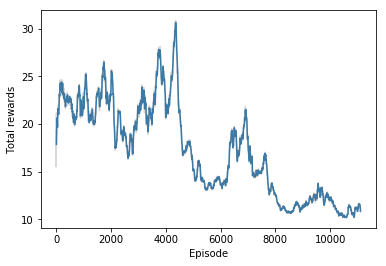

In [139]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

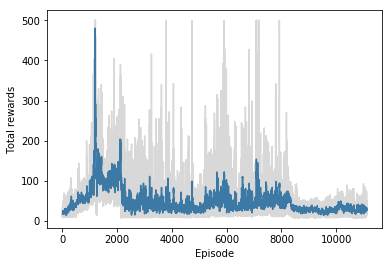

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

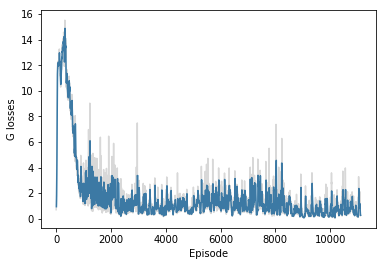

In [103]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

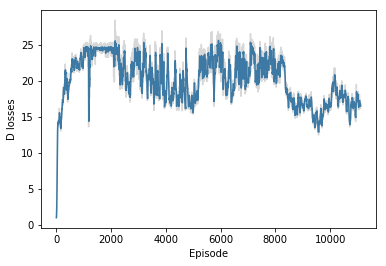

In [104]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.